# Project 1 - Data Engineering
## 2 Data Exploration and Analysis
This notebook is for the implementation of task "2 Data Exploration and Analysis", as listed in the **Project Instructions**.

<div class="alert alert-success">
<b>Overview:</b><br>
Data Exploration and Analysis consists of the following parts worth 70 points:
<ul>
    <li><b>E1 - Obtain and Scrub</b> (15 points)</li>
    <li><b>E2 - Exploratory data analysis (EDA) </b>(20 points)</li>
    <li><b>E3 - Formulate hypotheses </b>(25 points)</li>
    <li><b>Follow the guidelines for Data Exploration and Analysis below </b>(10 points)</li>
</ul></div>

<div class="alert alert-success">
<b>Guidelines for Data Exploration and Analysis:</b><br>
    <ol>
        <li>Use a single Jupyer notebook for your project.</li>
        <li>Use only Python-code for your project.</li>
        <li>The use of automatic and semi-automatic data analyis tools is not allowed (e. g., PandasGUI, D-Tale, Mito, etc.). Only use packages we used in the coded lectures.</li>
        <li>Export your environment for submission as 'prj01-environment.txt'.</li>
        <li>Upload your resulting work as a zip file containing only a single jupyter notebook and required files to run the notebook. All cell outputs and <b>figures must display in jupyter lab</b>. (Test this, in particular when you use another environment like VS Code.)</li>
        <li>All code cells in your notebook must be runnable without errors or warnings (e. g., deprecated functions). Each error/warning subtracts -2 points (up to the full 10 points for following the  guidelines).</li>
        <li>Use only relative paths in your project.</li>
        <li>Avoid (excessive) code duplication.</li>
        <li>Avoid loops iterating over pandas objects (Series, DataFrames). Explicitly justify each exception via a comment. </li>
        <li>All coded steps in your analysis must be commented.</li>
        <li>Keep your code as well as outputs short, precise and readable. Each long or unnecessary output subtracts -2 points (up to the full 10 points for following the project guidelines).</li>
    </ol>
    <b>Late submissions are not accepted and earn you 0 points on the python project. </b>
</div>

Explicitly list which notebook toolset was used (jupyter lab/jupyter notebook/VS Code/etc.) 

**here**: Jupyter Notebook, Pycharm

Explicitly and clearly state the chosen dataset number and title:
### Arbeitsmarkt ODÖ 
## 99. Gesamtübersicht über die Arbeitslosigkeit - Bestand, Zugang, Abgang


## E1 - Obtain and Scrub

In [27]:
# E0: setup imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import re


In [28]:
# E1:
# Personen in Schulung nach Alter und Berufswunsch - Bestand
# read csv file
df = pd.read_csv('Bestand_SC_Alter_Berufswunsch_RGS.csv', sep=';', encoding = 'ISO-8859-1', parse_dates=["Datum"])

df.info(), df['Unnamed: 8'].nunique()
# df['Unnamed 8'].describe()

KeyboardInterrupt: 

In [ ]:
# drop unnötige Column
df.drop('Unnamed: 8', axis = 1, inplace = True)
df.head()

In [ ]:
# definiere Geschlecht als Category, da nie mehr Werte zugelassen sein sollen
df['Geschlecht'] = df['Geschlecht'].astype('category') # only 2 values
df

In [ ]:
from concurrent.futures.thread import ThreadPoolExecutor

# Altersgruppe aufteilen, um Nummern separat als Int zu speichern (plotten, sortieren)
regex_pattern = re.compile(r'\d+')
def sep_age(age_range):
    numbers = regex_pattern.findall(age_range)
    if len(numbers) == 1:
        if age_range.startswith('bis'):
            return (0, int(numbers[0]))  # bis 19 Jahre
        else:
            return (int(numbers[0]), 99)  # 65 Jahre und Ã¤lter
    elif len(numbers) == 2:
        return (int(numbers[0]), int(numbers[1]))  # Lower and upper bounds
    return (None, None)  # Fallback case (if no match)

# Parallel processing using ThreadPoolExecutor
def parallel_apply(func, series):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(func, series))
    return pd.DataFrame(results, columns=['Lower Age', 'Upper Age'])

# Applying the optimized function in parallel
age = parallel_apply(sep_age, df['Altersgruppe'])
age

In [ ]:
# erstellen neuer Columns, um Altersgrenzen zu speichern
df['Alter_von'] = age['Lower Age']
df['Alter_bis'] = age['Upper Age']
df

In [ ]:
# Anzahlen von BerufsCode und Bezeichnung vergleichen
print(df['Berufs4Steller'].nunique(), df['Berufs4StellerBez'].nunique())
df['Datum'].value_counts()

In [ ]:
# fehlende Daten pro column anschauen
missing_data = df.isnull().sum()
missing_percentages = round((missing_data / len(df)) * 100, 2)

missing_percentages.sort_values(ascending=False)

In [ ]:
# erstellen eines neuen Datasets, welche Nan-Values enthält - für spätere Untersuchung
df_nan = df[df['Berufs4StellerBez'].isnull()] # dataset with NaN values (521 rows)
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

In [ ]:
# erstellen eines neuen Datasets, welche "unbestimmte"-Values enthält - für spätere Untersuchung
df_unbest = df[df['Berufs4Steller']=='B9999'] # unbestimmt (nur Pst) ~Personenstammdaten? 
df_missing = pd.concat([df_unbest, df_nan])
print(df_unbest.shape)
print(f"Missing values percentage: {round((len(df_unbest) / len(df)) * 100, 2)}")
df_missing

In [ ]:
# "unbestimmte" Daten aus dem Haupt-Dataset entfernen
print(df.shape)
df.drop(df[df['Berufs4Steller']=='B9999'].index, inplace=True)
print(df.shape)

In [ ]:
# duplikate anzeigen; mit allen und einem Subset von Columns
print(df[df.duplicated(keep=False)]) # completely duplicated rows
subset = df.columns
subset = subset.drop('BESTAND')
print(df[df.duplicated(subset=subset, keep=False)])

In [ ]:
# bereinigte Daten in ein csv File speichern (zu viele Daten für Excel)
df.to_csv('clean_data.csv')

In [ ]:
# alle Datentypen anzeigen
df.info()

In [ ]:
# kleinstes, größtes und median Datum anzeigen
df['Datum'].min(), df['Datum'].median(), df['Datum'].max(),

In [ ]:
# Anzahl der einzigartigen RGSCodes anzeigen und ihre Häufigkeit
print(df['RGSCode'].nunique())
df['RGSCode'].value_counts()

In [ ]:
# Anzahl der einzigartigen RGSNamen anzeigen und ihre Häufigkeit
print(df['RGSName'].nunique())
df['RGSName'].value_counts()

In [ ]:
# Anzahl der einzigartigen Geschlechter anzeigen und ihre Häufigkeit
print(df['Geschlecht'].nunique())
df['Geschlecht'].value_counts()

In [ ]:
# Anzahl der einzigartigen Altersgruppen anzeigen und ihre Häufigkeit
print(df['Altersgruppe'].nunique())
df['Altersgruppe'].value_counts()

In [ ]:
# kleinste, größte und median untere Altersgrenze 
df['Alter_von'].min(), df['Alter_von'].median(), df['Alter_von'].max()

In [ ]:
# kleinste, größte und median obere Altersgrenze 
df['Alter_bis'].min(), df['Alter_bis'].median(), df['Alter_bis'].max()

In [ ]:
# Anzahl der einzigartigen Berufs4Steller anzeigen und ihre Häufigkeit
print(df['Berufs4Steller'].nunique())
df['Berufs4Steller'].value_counts()

In [ ]:
# Anzahl der einzigartigen Berufs4StellerBezeichnungen anzeigen und ihre Häufigkeit
print(df['Berufs4StellerBez'].nunique())
df['Berufs4StellerBez'].value_counts()

In [ ]:
# Anzahl der einzigartigen Bestände anzeigen + kleinste, größte und median von Bestand
print(df['BESTAND'].nunique())
print(df['BESTAND'].min(), df['BESTAND'].median(), df['BESTAND'].max())
df['BESTAND'].value_counts()


In [ ]:
# E2:


In [ ]:
# geopandas_dataframe für Bundesländergrenzen laden
gdf = gpd.read_file("laender_95_geo.json")

gdf.plot()
plt.show()

In [ ]:
gdf.head()

In [ ]:
# dataframe für Kategorisierung der Berufe laden
df_zuordnungen = pd.read_excel('24-598_AMS-Berufssystematik_Stand_05-2024.xlsx', dtype=str)
df_zuordnungen

In [ ]:
# Anzahl der unterschiedlichen Kategorien vergleichen
df_zuordnungen['1-St.'].nunique(), df_zuordnungen['2-St.'].nunique()
#print(df_zuordnungen['Berufsabteilung'].nunique()) # 7 verschiedene da Stufe 1,2,3 gleich sind


In [ ]:
# B von Berufscodes entfernen, um mit den Kategorien zu mergen
df['Berufs4Steller'] = df['Berufs4Steller'].replace('B', '', regex=True)
df

In [ ]:
# Auswahl der interessanten Columns, um keine unnötigen Daten hinzuzufügen
# Mergen des Originaldatensets mit der Auswahl der Kategorie-Columns
df_zuordnungen_small = df_zuordnungen[['4-St.', 'Berufsobergruppe']].drop_duplicates()
merged_df = df.merge(df_zuordnungen_small, left_on='Berufs4Steller', right_on='4-St.', how='inner')
#df_zuordnungen_small
merged_df

In [ ]:
# https://www.ams.at/content/dam/download/allgemeine-informationen/001_amd-online_verzeichnis_arbeitsmarktbezirke.pdf
# manuelles Mappen der Bundesländer, um aus der ersten Ziffer der RGSCodes auf das zugehörige Bundesland zu schließen
bundesland_mapping = {
    '1': 'Burgenland',
    '2': 'Kärnten',
    '3': 'Niederösterreich',
    '4': 'Oberösterreich',
    '5': 'Salzburg',
    '6': 'Steiermark',
    '7': 'Tirol',
    '8': 'Vorarlberg',
    '9': 'Wien'
}

# extract first character of RGSCode and map to Bundesland
merged_df['Bundesland'] = merged_df['RGSCode'].astype(str).str[0].map(bundesland_mapping)
merged_df.drop('4-St.', axis=1, inplace=True) # doppelte Daten, nur zum Mergen benötigt
merged_df.head()

In [ ]:
# fehlende Daten bei neu gemergeden dataframe checken
missing_data = merged_df.isnull().sum()
missing_percentages = round((missing_data / len(merged_df)) * 100, 2)

missing_percentages.sort_values(ascending=False)

In [ ]:
# exportieren der gemergeden Daten als csv
merged_df.to_csv('merged_data.csv')
#merged_df = pd.read_csv('merged_data.csv', parse_dates=['Datum'], encoding='ISO-8859-1')

In [ ]:
# Top-10 Bestand überprüfen, um mögliche Outlier zu identifizieren
df_top_10_bestand = merged_df.sort_values(by='BESTAND', ascending=False)[:10]
df_top_10_bestand

In [ ]:
# Anzahl der SchulungsteilnehmerInnen pro Bundesland in Summe von 2019 bis 2024

grouped_data = merged_df.groupby('Bundesland')['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='Bundesland', y='BESTAND', hue='Bundesland')

plt.title('SchulungsteilnehmerInnen pro Bundesland Summe von 2019 - 2024')
plt.ylabel('Summe vom BESTAND')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5)

plt.grid()
plt.show()

In [ ]:
# ein neues Dataframe erzeugen, um die Geodaten der Bundesländer hinzuzufügen
geo_df = merged_df.merge(gdf, left_on='Bundesland', right_on='name', how='inner')
geo_df.drop(['iso', 'name'], axis=1, inplace=True)
geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry') # nur ein DataFrame nach merge, also in gpd umwandeln
geo_df

In [ ]:
grouped_data = merged_df.groupby(['Bundesland'])['BESTAND'].sum().reset_index()
grouped_data = grouped_data.merge(gdf, left_on='Bundesland', right_on='name', how='inner')
grouped_data.drop(['iso', 'name'], axis=1, inplace=True)
grouped_data = gpd.GeoDataFrame(grouped_data, geometry='geometry')
grouped_data.sort_values(by=['BESTAND'], inplace = True) # sort values for color mapping to work


# Plotten von Bestand pro Bundesland in Österreich von 2019 bis 2024
fig, ax = plt.subplots(figsize=(10, 8))

# Normalisieren von den Bestands-Werten für das Color-Mapping 
norm = plt.Normalize(vmin=grouped_data['BESTAND'].min(), 
                     vmax=grouped_data['BESTAND'].max())

cmap = plt.get_cmap('Oranges') # Orange Colormap

grouped_data.plot(column='BESTAND', ax=ax, cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) # normalize to fit full spectrum
#sm._A = []
# Colorbar formatieren
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('BESTAND')
cbar.ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Bestand pro Bundesland in Österreich von 2019 bis 2024")
plt.show()


In [ ]:
# Anzahl der SchulungsteilnehmerInnen pro Geschlecht in Summe von 2019 bis 2024
grouped_data = merged_df.groupby('Geschlecht', observed = False)['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='Geschlecht', y='BESTAND', width=0.5, hue='Geschlecht')

plt.title('SchulungsteilnehmerInnen pro Geschlecht Summe insgesamt von 2019 - 2024')
plt.ylabel('Summe vom BESTAND')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

max_value = grouped_data['BESTAND'].max()
plt.ylim(0, max_value * 1.1)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5)

plt.show()

In [ ]:
# Anzahl der SchulungsteilnehmerInnen pro Jahr und Geschlecht 2019 bis 2024
grouped_data = merged_df.groupby([merged_df['Datum'].dt.year, 'Geschlecht'], observed=False)['BESTAND'].sum().reset_index()
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='Datum', y='BESTAND', hue='Geschlecht')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Summe von Bestand')
plt.title('SchulungsteilnehmerInnen pro Jahr und Geschlecht 2019 - 2024')

max_value = grouped_data['BESTAND'].max()
plt.ylim(0, max_value * 1.1)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5)



In [29]:
# Vorbereitung der Daten für Plot 
grouped_data = merged_df.groupby(['Altersgruppe', 'Alter_von','Geschlecht'], observed=True)['BESTAND'].sum().reset_index()
# Bestände von 0 sind immer überflüssige Rows
grouped_data.drop(grouped_data[grouped_data['BESTAND'] == 0].index, inplace=True)
grouped_data.sort_values(by='Alter_von', inplace=True)
grouped_data

NameError: name 'merged_df' is not defined

In [30]:
# Anzahl der SchulungsteilnehmerInnen pro Altersgruppe pro Geschlecht von 2019 bis 2024
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=grouped_data, x='Altersgruppe', y='BESTAND', hue='Geschlecht')

plt.title('SchulungsteilnehmerInnen pro Altersgruppe pro Geschlecht von 2019 - 2024')
plt.ylabel('Summe von SchulungsteilnehmerInnen')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5, )

plt.grid()
plt.show()

NameError: name 'grouped_data' is not defined

<Figure size 1500x800 with 0 Axes>

In [31]:
# Anzahl der SchulungsteilnehmerInnen pro Altersgruppe von 2019 bis 2024
grouped_data = merged_df.groupby(['Altersgruppe', 'Alter_von'])['BESTAND'].sum().reset_index().sort_values(by='Alter_von')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='Altersgruppe', y='BESTAND', hue='Altersgruppe')

plt.title('SchulungsteilnehmerInnen pro Altersgruppe von 2019 - 2024')
plt.ylabel('Summe von SchulungsteilnehmerInnen')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

max_value = grouped_data['BESTAND'].max()
plt.ylim(0, max_value * 1.1)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5)

plt.grid()
plt.show()

NameError: name 'merged_df' is not defined

In [32]:
# Veränderung der Anzahl der SchulungsteilnehmerInnen von 2019 bis 2024
grouped_data = df.groupby('Datum')['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Datum', y='BESTAND', marker='o')

plt.title('SchulungsteilnehmerInnen-Veränderung von 2019 - 2024')
plt.xlabel('Datum')
plt.ylabel('Summe von SchulungsteilnehmerInnen')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x00000285D78A82C0> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000285A09E7920>>
Traceback (most recent call last):
  File "C:\Users\Marlis Tiefengraber\PycharmProjects\pythonProject\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Marlis Tiefengraber\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
# Anzahl der SchulungsteilnehmerInnen mit unbestimmtem Berufswunsch von 2019 bis 2024
grouped_data = df_unbest.groupby(['Datum'])['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=grouped_data, x='Datum', marker='o', y='BESTAND')

plt.title('SchulungsteilnehmerInnen mit unbestimmten Berufswunsch von 2019 - 2024')
plt.ylabel('Summe von SchulungsteilnehmerInnen')
plt.xticks(rotation=45, ha='right')

plt.grid(True)
plt.show()

In [ ]:
# Anzahl der SchulungsteilnehmerInnen mit NaN Berufswunsch von 2019 bis 2024
grouped_data = df_nan.groupby(['Datum'])['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=grouped_data, x='Datum', marker='o', y='BESTAND')

plt.title('SchulungsteilnehmerInnen mit unbestimmten Berufswunsch von 2019 - 2024')
plt.ylabel('Summe von SchulungsteilnehmerInnen')
plt.xticks(rotation=45, ha='right')

plt.grid(True)
plt.show()

In [ ]:
# Anzahl der SchulungsteilnehmerInnen pro Berufsobergruppe von 2019 bis 2024
grouped_data = merged_df.groupby(['Berufsobergruppe'])['BESTAND'].sum().reset_index()
ilp = px.bar(grouped_data, 
    x='Berufsobergruppe', 
    y='BESTAND', 
    color='Berufsobergruppe',
    title="SchulungsteilnehmerInnen pro Berufsobergruppe von 2019 - 2024",
    labels={"Berufsobergruppe": "Obergruppen der Berufe", "BESTAND": "Bestand"} # labels the axes
    )


# add legend
ilp.update_layout(
    xaxis=dict(showticklabels=False),
    legend_title_text='Berufsobergruppe', 
    width=1200, 
    height=600,
    legend=dict(
        orientation="v", # vertical
        font=dict(size=10)
    )
)

ilp.show()


In [ ]:
# Anzahl der SchulungsteilnehmerInnen pro Berufsobergruppe von 2019 bis 2024
grouped_data = merged_df.groupby(['Berufsobergruppe'])['BESTAND'].sum().reset_index()

fig = px.treemap(
    grouped_data, 
    path=['Berufsobergruppe'],
    values='BESTAND',
    title='SchulungsteilnehmerInnen pro Berufsobergruppe von 2019 - 2024',
    color='BESTAND',
    color_continuous_scale='Viridis'
)

# Update layout to ensure clear labeling
fig.update_traces(textinfo='label+value+percent entry')  # Show label, value, and percentage on each box
fig.update_traces(hovertemplate='<b>Label:</b> %{label}<br>'
                                '<b>Value:</b> %{value}<br>'
                                '<b>Percentage:</b> %{percentRoot:.0%}<extra></extra>')

fig.show()

In [ ]:
# Top 10 Jobwünsche von 2019 bis 2024
grouped_data = merged_df.groupby(['Berufs4StellerBez'])['BESTAND'].sum().reset_index().sort_values(by='BESTAND', ascending=False)
grouped_data = grouped_data[:10]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='Berufs4StellerBez', y='BESTAND', hue='Berufs4StellerBez')

plt.title('Top 10 Jobwünsche von 2019 - 2024')
plt.ylabel('Summe von Jobwünschen')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

max_value = grouped_data['BESTAND'].max()
plt.ylim(0, max_value * 1.1)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=5)

plt.grid()
plt.show()

In [ ]:
# Top 3 Berufswünsche pro Jahr auswählen
grouped_data = merged_df.groupby([merged_df['Datum'].dt.year, 'Berufs4StellerBez'])['BESTAND'].sum().reset_index()
grouped_data = grouped_data.groupby('Datum').apply(lambda x: x.nlargest(3, 'BESTAND')).reset_index(drop=True)

grouped_data

In [ ]:
# Top 3 Jobwünsche pro Jahr von 2019 bis 2024
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=grouped_data, x='Datum', y='BESTAND', hue='Berufs4StellerBez', width=0.5)

plt.title('Top 3 Jobwünsche pro Jahr von 2019 - 2024')
plt.ylabel('Summe von Jobwünschen')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

max_value = grouped_data['BESTAND'].max()
plt.ylim(0, max_value * 1.1)

for container in ax.containers:
    labels = ax.bar_label(container, fmt='{:,.0f}', label_type='edge', padding=3)
    for label in labels:
        #label.set_rotation(45)
        label.set_horizontalalignment('left')     
    
plt.legend(title='Berufsbezeichnung', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.show()

## E3 - Formulate hypotheses

*Note: Read this section entirely and understand it - every group member.*

A hypothesis is an idea or explanation for something that is based on known facts but has not yet been proved. A hypothesis is a compact, concise statement, such as: "Individuals with higher income have (on average) more offspring.", that will be answered based on facts (the data). https://gradcoach.com/what-is-a-research-hypothesis-or-scientific-hypothesis/

Formulate *N* non-trivial hypotheses, 1 per group member, and regard the following criteria: 
- State the hypothesis explicitly in concise language. 
- The hypothesis must be **motivated** by either **EDA results** or **literature** (citation in the report needed).
- The hypothesis must refer to **endpoints** that are **testable**. Specifically, the endpoint must be derived from the data.
- Think of real-life use cases/consequences of your results (textual description). 
- For each hypothesis explain all executed steps. 
- In case of extreme or implausible results check the validity of your data.
- For each hypothesis export the artifacts (figures, tables, etc.) required for the report.
- If you decide to use a statistical test, use it properly. In particular, check the validity and comparability of the samples.

Do not:
- State nebulous, vague hypotheses. These don't contain endpoints and are unclear to test (i.e., answer).
- Use post-hoc hypotheses. Portraying an empirically inspired **post hoc hypothesis as a priori** violates the **falsification principle** crucial for hypothesis-driven (that is, confirmatory) empirical research. Falsification is severe scientific fraud.
- State trivial hypotheses (e.g., hypthesis 2: "Not Hypothesis 1").
- Answer based on "common knowledge".
- Try to **produce positively tested hypotheses**. If a well motivated hypothesis is negative, this is an important finding (see Simpson's Paradox). The value of a tested hypothesis lies in the information or learning it provides.

Example: The homework with Simpson's Paradox. The pooled overall comparison between the genders would be the EDA motivating the hypothesis: "At UC Berkeley the by-department admissions rate for females is lower than for males." It should be tested using samples of department admission rates for the 2 **groups** male and female. No steps of the test should be done in EDA (or a priory to stating the hypothesis). The groups should be compared graphically, e.g., via a stripplot overlayed with a boxplot. The figure should be labelled properly and exported for the report. A (paired) t-test **may** be used (it's optional) to test this hypothesis statistically. For different data (e.g., time series) different approaches may be required. You don't have to use statistical tests, in particular if you don't know what they are doing.


### E3-H1: "xxx"
Author: Group member 1


In [33]:
# hypothesen:
# Anzahl der Frauen, die Ausb. im Bereich Technik machen, ist von 2019 bis 2024 signifikant angestiegen
# Anzahl der Frauen, die Ausb. im Bereich Technik machen, ist in Wien (und Graz) signifikant höher als im Rest Österreichs

### E3-H2: "Die Verteilung/Time Series der Anzahl der SchulungsteilnehmerInnen im Beobachtungszeitraum (2019-2024) ist kein Random Walk "
Author: Marlis Tiefengraber

Quellen:
- https://machinelearningmastery.com/time-series-data-stationary-python/ [1]
- https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/ [2]
- https://prof-frenzel.medium.com/kb-time-series-data-part-3-6e32032f7b49 [3]

Ein Random Walk ist als eine non-stationary Time Series mit Werten, die eine direkte Veränderung ihres Vorgängers sind, definiert. Die Autocorrelation eines Random Walks ist stark zwischen benachbarten Werten, fällt mit zunehmender Entfernung aber ab. Das bedeutet, dass Random Walks keine lernbare Struktur haben und damit auch nicht vorhersagbar sind.[2]


In [34]:
df = pd.read_csv('clean_data.csv', parse_dates=['Datum'])
df.head()


KeyboardInterrupt: 

In [ ]:
grouped_data = df.groupby('Datum')['BESTAND'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Datum', y='BESTAND', marker='o')

plt.title('SchulungsteilnehmerInnen-Veränderung von 2019 - 2024')
plt.xlabel('Datum')
plt.ylabel('Summe von SchulungsteilnehmerInnen')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Sind die Daten stationary oder non-stationary?

Saisonalität ist bei dem Plot zu erkennen, was auf eine non-stationary Time Series hindeutet.

In [34]:
df_ts = df.groupby('Datum').describe() 
df_ms = df_ts['BESTAND'][['mean', 'std']]
df_ms

KeyboardInterrupt: 

Mean und Standardabweichung sind relativ konstant, was wiederum auf eine stationary Time Series hindeuten könnte. Um genauere Informationen über die Verteilung der Werte zu erhalten, werden sie in einem Histogramm geplottet. Eine Gauß'sche Verteilung würde ebenfalls auf eine stationary Time Series hindeuten. [1]

In [ ]:
df.groupby('Datum')['BESTAND'].sum().hist()
plt.show()
df_ms['mean'].hist()
plt.show()

Die Histogramme der Summe der monatlichen Schulungsteilnehmer und deren Mittelwert sprechen eindeutig gegen eine Gauß'sche Verteilung der Daten, was eine stationary Time Series wieder unwahrscheinlicher macht.


Um mehr Gewissheit über das Verhalten der Time Series zu erhalten, wird der Augmented Dickey-Fuller Test durchgeführt. 
Dieser überprüft eine Time Series auf eine Unit Root, also wie sehr sie von einem Trend definiert ist. 

Die Null-Hypothese bei diesem Test ist, dass die Time Series non-stationary ist. Der Test wird mithilfe der p-Wert und der ADF Statistik ausgewertet. [1]

In [35]:
from statsmodels.tsa.stattools import adfuller
group = df.groupby('Datum')['BESTAND'].sum()
result = adfuller(group.values)
print('Sample Size: ', len(group))
print('ADF StatistiK: %f' % result[0])
print('p-Wert: %f' % result[1])
print('Werte für Konfidenzlevel:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


ERROR! Session/line number was not unique in database. History logging moved to new session 86



KeyboardInterrupt



Um die Null-Hypothese beizubehalten, müssen folgende Bedingungen erfüllt sein: 
- Die p-Variable muss über der designierten Schwelle liegen
- die ADF Statistik muss größer als der Wert des designierten Konfidenzlevels

Typischerweise liegt die Schwelle des p-Werts bei 0.01 oder 0.05; hier liegt der errechnete Wert von 0.82 darüber. 

Ebenefalls ist erkennbar, dass die ADF Statistik mit - 0.79 über den Werten aller 3 Konfidenzlevel liegt.

Je größer nun p-Wert und ADF Statistik, desto wahrscheinlicher ist die Null-Hypothese. Bei berechneten Werten ist es also relativ wahrscheinlich, dass die Time Series non-stationary ist und eine Unit Root hat. [2]

Das spricht nicht gegen einen Random Walk. Daher wird als Nächstes die Autocorrelation betrachtet.



In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(group.values, lags=len(group)-1)
plt.show()


In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(group.values)

In beiden Plots kann sehr geringe Autocorrelation erkannt werden.
- Im ersten Plot ist dies klar erkennbar, da die Korrelation immer im blauen Bereich nah an 0 liegt, was zeigt, dass sie insignifikant ist
- Im zweiten Plot sieht man noch etwas genauer, dass die Korrelation sehr nah um 0 herum ausfällt und fast immer innerhalb des 99% (- -) und 95% (--)Konfidenzintervalls ist, wodurch sie insignifikant ist

Die geringe und vor allem auch abfallende Autocorrelation spricht ebenfalls für einen Random Walk

Als Nächstes wird versucht, die Time Series stationary zu machen, um klarer erkennen zu können, ob eine lernbare Struktur existiert. Dafür wird erst zum ersten Grad differenziert und dann die saisonalen Trends entfernt. [3]

In [36]:
group_1st_diff = group.diff(1)
group_1st_diff.dropna(inplace=True)
autocorrelation_plot(group_1st_diff)

NameError: name 'group' is not defined

In [37]:
result = adfuller(group_1st_diff)
print('Sample Size: ', len(group_1st_diff))
print('ADF StatistiK: %f' % result[0])
print('p-Wert: %f' % result[1])
print('Werte für Konfidenzlevel:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


NameError: name 'adfuller' is not defined

Nach dem Differenzieren ersten Grades kann sowohl an der Autocorrelation als auch an dem p-Wert und der ADF Statistik erkannt werden, dass die Time Series noch nicht ganz als stationary anerkannt werden kann, aber dem näher liegt als die Originaldaten.

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(group_1st_diff, model='additive', period=12)  # Monthly data with yearly seasonality
group_2nd_diff = group_1st_diff - result.seasonal
autocorrelation_plot(group_2nd_diff)

NameError: name 'group_1st_diff' is not defined

In [39]:
result = adfuller(group_2nd_diff)
print('Sample Size: ', len(group_2nd_diff))
print('ADF StatistiK: %f' % result[0])
print('p-Wert: %f' % result[1])
print('Werte für Konfidenzlevel:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

NameError: name 'adfuller' is not defined

Nach der Entfernung der saisonalen Trends ist die Time Series annähernd stationary. Der p-Wert liegt unter 0.05 und die ADF Statistik ist kleiner als das 5% Konfidenzintervall, wodurch die Null-Hypothese (Die Time Series ist non-stationary) abgelehnt werden kann.

In [40]:
group_2nd_diff_df = pd.DataFrame(group_2nd_diff)
group_2nd_diff_df.reset_index(inplace=True)
plt.figure(figsize=(10, 6))
sns.lineplot(data=group_2nd_diff_df, x='Datum', y='BESTAND', marker='o')

plt.title('Stationary Time Series')
plt.xlabel('Datum')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

NameError: name 'group_2nd_diff' is not defined

Eine offensichtlich lernbare Struktur ist nun nicht mehr zu sehen, was ebenfalls dafür spricht, dass die Time Series ein Random Walk ist

Nun wird noch mit dem Persistence Model eine Vorhersage für die Werte getroffen, da dieses bei einem Random Walk die besten Ergebnisse liefert. Ein Persistence Model trifft für jeden Wert in der Time Series die Vorhersage, dass er gleich wie sein Vorgänger ist.

In [41]:
from sklearn.metrics import mean_squared_error
group = pd.DataFrame(group).reset_index()
group['predicted'] = group['BESTAND'].shift(1)
group.dropna(inplace=True)
# RMSE
rmse = np.sqrt(mean_squared_error(group['BESTAND'], group['predicted']))
print(f'RMSE: {rmse}')

NameError: name 'group' is not defined

### E3-H3: "Bei Personen unter 30 Jahren ist der Anteil der Berufswünsche nach einem für ihr Geschlecht untypischen Beruf größer als bei Personen über 30. (Bei unter 30-Jährigen ist der Anteil der Frauen, die in Männerberufen arbeiten wollen und der Männer, die in Frauenberufen arbeiten wollen, größer als bei über 30-Jährigen)" ###

Author: Marlis Tiefengraber

Sources: 
- https://www.zeit.de/arbeit/2024-04/maennerberufe-frauenanteil-zuwachs-girls-day-boys-day
- https://www.arbeitswelt-portal.de/ausbildung/artikel/typisch-mann-typisch-frau-wie-eine-stereotype-berufswahl-ungleichheit-verstaerkt

1. Choose male and female dominated jobs to test the hypothesis on
2. Show the share of men and women in these jobs per year (1st overview)
3. Show the changes in share of men and women with aspirations for these jobs for each job per year (2nd overview, trend)
4. Show/Compare the share of women/men under and over 30 with job aspirations for jobs dominated by the opposite gender ((dis)proving the hypothesis)
5. Show/Compare the share of women/men under and over 30 for each job group separately (analyzing result of hypothesis testing)

Read the csv prepared in step E1 and E2. Only use useful columns to avoid a clunky dataframe.

Columns used:
- Datum: to look at data in yearly granularity, compare development
- Geschlecht: to split data per gender, hypothesis only answerable with this feature
- Berufsobergruppe: to separate jobs into female and male dominated fields
- BESTAND: to calculate numbers and percentages
- Alter_bis: to form age groups

In [85]:
df = pd.read_csv('merged_data.csv', parse_dates=['Datum'],usecols=['Datum', 'Geschlecht', 'Berufsobergruppe', 'BESTAND', 'Alter_bis'] )
df.head()

,Datum,Geschlecht,BESTAND,Alter_bis,Berufsobergruppe
0,2019-01-31,Frauen,1,19,"Ackerbau-, Tierzucht-, Gartenbauberufe"
1,2019-01-31,Frauen,1,54,"Ackerbau-, Tierzucht-, Gartenbauberufe"
2,2019-01-31,Männer,2,19,"Ackerbau-, Tierzucht-, Gartenbauberufe"
3,2019-01-31,Frauen,2,19,"Ackerbau-, Tierzucht-, Gartenbauberufe"
4,2019-01-31,Frauen,1,34,"Ackerbau-, Tierzucht-, Gartenbauberufe"


grouping to sum up counts of people per Date (yearly granularity is enough), per job group and per gender

once with age grouping included to calculate statistics for the whole populace and the age groups separately

In [86]:
df_group_age=df.groupby([df['Datum'].dt.year, 'Berufsobergruppe', 'Geschlecht', 'Alter_bis'], observed=False)['BESTAND'].sum().reset_index()
df_group = df.groupby([df['Datum'].dt.year, 'Berufsobergruppe', 'Geschlecht'], observed=False)['BESTAND'].sum().reset_index()
df_group_age.head(), df_group.head()

(   Datum                        Berufsobergruppe Geschlecht  Alter_bis  \
 0   2019  Ackerbau-, Tierzucht-, Gartenbauberufe     Frauen         19   
 1   2019  Ackerbau-, Tierzucht-, Gartenbauberufe     Frauen         24   
 2   2019  Ackerbau-, Tierzucht-, Gartenbauberufe     Frauen         29   
 3   2019  Ackerbau-, Tierzucht-, Gartenbauberufe     Frauen         34   
 4   2019  Ackerbau-, Tierzucht-, Gartenbauberufe     Frauen         39   
 
    BESTAND  
 0     2917  
 1     1811  
 2      659  
 3      496  
 4      323  ,
    Datum                                   Berufsobergruppe Geschlecht  \
 0   2019             Ackerbau-, Tierzucht-, Gartenbauberufe     Frauen   
 1   2019             Ackerbau-, Tierzucht-, Gartenbauberufe     Männer   
 2   2019  Architekt(en)innen, Techniker/innen für Bauwes...     Frauen   
 3   2019  Architekt(en)innen, Techniker/innen für Bauwes...     Männer   
 4   2019                                          Bauberufe     Frauen   
 
    BESTAND

get all possible job groups to decide which to choose to represent female and male jobs

as not all job groups are decidedly more female or male populated, representatives were chosen (source: https://www.arbeitswelt-portal.de/ausbildung/artikel/typisch-mann-typisch-frau-wie-eine-stereotype-berufswahl-ungleichheit-verstaerkt)

In [87]:
df_group['Berufsobergruppe'].unique()

array(['Ackerbau-, Tierzucht-, Gartenbauberufe',
       'Architekt(en)innen, Techniker/innen für Bauwesen, Vermessungswesen',
       'Bauberufe',
       'Bekleidungshersteller/innen, andere Textilverarbeiter/innen',
       'Berufe des religiösen Dienstes',
       'Bildende Künste und verwandte Berufe',
       'Boten, Amts-, Büro- und Geschäftsdiener/innen',
       'Buchhalter/innen, Kassier(e)innen und verwandte Berufe',
       'Chemie-, Gummiarbeiter/innen, Kunststoffverarbeiter/innen',
       'Chemischputzer/innen, Wäscher/innen, Bügler/innen',
       'Darstellende Künstler/innen, Musiker/innen',
       'Dienstleistungsberufe des Gesundheitswesens',
       'Eisen-, Metallgewinner/innen, Walzer/innen, Gießer/innen',
       'Elektriker/innen',
       'Erdöl- und Erdgasgewinner/innen, übrige Tiefbohrer/innen',
       'Forstarbeiter/innen, Jagd-, Fischerberufe',
       'Friseur(e)innen, Schönheitspfleger/innen und verwandte Berufe',
       'Fürsorger/innen, Sozialarbeiter/innen', 'Gesund

In [88]:
# https://www.arbeitswelt-portal.de/ausbildung/artikel/typisch-mann-typisch-frau-wie-eine-stereotype-berufswahl-ungleichheit-verstaerkt
female_jobs = ['Buchhalter/innen, Kassier(e)innen und verwandte Berufe','Reinigungsberufe anderer Art', 'Friseur(e)innen, Schönheitspfleger/innen und verwandte Berufe', 'Lehrer/innen, Erzieher/innen ohne Turn-, Sportlehrer/innen', 'Haushälter/innen, Hausgehilf(en)innen, Hauswart(e)innen', 'Fürsorger/innen, Sozialarbeiter/innen', 'Gesundheitsberufe']
male_jobs = ['Bauberufe', 'Eisen-, Metallgewinner/innen, Walzer/innen, Gießer/innen', 'Maschineneinrichter/innen, Berufe der maschinellen Metallbearbeitung', 'Sicherheitsorgane (m./w.)', 'Techniker/innen für Chemie, Physik, Chemiker, Physiker (m./w.)', 'Ackerbau-, Tierzucht-, Gartenbauberufe', 'Forstarbeiter/innen, Jagd-, Fischerberufe']

len(female_jobs), len(male_jobs)

(7, 7)

pivoting the dataframe to get gender as columns, facilitates calculations later

done separately for the dataframe including the age groups 

In [89]:
df_pivot = df_group.pivot_table(index=['Datum', 'Berufsobergruppe'], columns=['Geschlecht'], values='BESTAND', aggfunc='sum').fillna(0)
df_pivot_age = df_group_age.pivot_table(index=['Datum', 'Berufsobergruppe', 'Alter_bis'], columns=['Geschlecht'], values='BESTAND', aggfunc='sum').fillna(0)
# rename to get rid of multiindex
df_pivot.columns = ['Frauen', 'Männer']
df_pivot_age.columns = ['Frauen', 'Männer']
df_pivot.head(10)

Frauen   Männer
Datum Berufsobergruppe                                                   
2019  Ackerbau-, Tierzucht-, Gartenbauberufe              6979.0   6506.0
      Architekt(en)innen, Techniker/innen für Bauwese...   753.0   1633.0
      Bauberufe                                           2235.0  25531.0
      Bekleidungshersteller/innen, andere Textilverar...  4495.0   1923.0
      Berufe des religiösen Dienstes                        29.0     68.0
      Bildende Künste und verwandte Berufe                 873.0    353.0
      Boten, Amts-, Büro- und Geschäftsdiener/innen         37.0    235.0
      Buchhalter/innen, Kassier(e)innen und verwandte...  8798.0   2110.0
      Chemie-, Gummiarbeiter/innen, Kunststoffverarbe...   531.0   1102.0
      Chemischputzer/innen, Wäscher/innen, Bügler/innen    908.0    268.0

In [90]:
df_pivot_age.head()

Frauen  Männer
Datum Berufsobergruppe                       Alter_bis                
2019  Ackerbau-, Tierzucht-, Gartenbauberufe 19         2917.0  2000.0
                                             24         1811.0  1627.0
                                             29          659.0   683.0
                                             34          496.0   501.0
                                             39          323.0   410.0

calculating percentages of men and women per job group

In [91]:
df_pivot['Gesamt'] = df_pivot['Männer'] + df_pivot['Frauen']
df_pivot_age['Gesamt'] = df_pivot_age['Männer'] + df_pivot_age['Frauen']

# Prozentanteil berechnen
df_pivot['% Frauen'] = df_pivot['Frauen'] / df_pivot['Gesamt'] * 100
df_pivot['% Männer'] = df_pivot['Männer'] / df_pivot['Gesamt'] * 100
df_pivot_age['% Frauen'] = df_pivot_age['Frauen'] / df_pivot_age['Gesamt'] * 100
df_pivot_age['% Männer'] = df_pivot_age['Männer'] / df_pivot_age['Gesamt'] * 100

df_pivot = df_pivot.reset_index()
df_pivot_age = df_pivot_age.reset_index()
df_pivot.head()

,Datum,Berufsobergruppe,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",6979.0,6506.0,13485.0,51.753801,48.246199
1,2019,"Architekt(en)innen, Techniker/innen für Bauwes...",753.0,1633.0,2386.0,31.559095,68.440905
2,2019,Bauberufe,2235.0,25531.0,27766.0,8.049413,91.950587
3,2019,"Bekleidungshersteller/innen, andere Textilvera...",4495.0,1923.0,6418.0,70.037395,29.962605
4,2019,Berufe des religiösen Dienstes,29.0,68.0,97.0,29.896907,70.103093


In [92]:
df_pivot_age.head()

,Datum,Berufsobergruppe,Alter_bis,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",19,2917.0,2000.0,4917.0,59.324792,40.675208
1,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",24,1811.0,1627.0,3438.0,52.675974,47.324026
2,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",29,659.0,683.0,1342.0,49.105812,50.894188
3,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",34,496.0,501.0,997.0,49.749248,50.250752
4,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",39,323.0,410.0,733.0,44.065484,55.934516


removing all job groups that are not in female or male jobs and therefore irrelevant 

In [93]:
df_jobs = df_pivot[df_pivot['Berufsobergruppe'].isin(female_jobs + male_jobs)]
df_jobs_age = df_pivot_age[df_pivot_age['Berufsobergruppe'].isin(female_jobs + male_jobs)]
df_jobs

,Datum,Berufsobergruppe,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",6979.0,6506.0,13485.0,51.753801,48.246199
2,2019,Bauberufe,2235.0,25531.0,27766.0,8.049413,91.950587
7,2019,"Buchhalter/innen, Kassier(e)innen und verwandt...",8798.0,2110.0,10908.0,80.656399,19.343601
12,2019,"Eisen-, Metallgewinner/innen, Walzer/innen, Gi...",3.0,150.0,153.0,1.960784,98.039216
15,2019,"Forstarbeiter/innen, Jagd-, Fischerberufe",11.0,183.0,194.0,5.670103,94.329897
...,...,...,...,...,...,...,...
390,2024,"Lehrer/innen, Erzieher/innen ohne Turn-, Sport...",11066.0,1536.0,12602.0,87.811458,12.188542
392,2024,"Maschineneinrichter/innen, Berufe der maschine...",451.0,1661.0,2112.0,21.354167,78.645833
398,2024,Reinigungsberufe anderer Art,447.0,810.0,1257.0,35.560859,64.439141
402,2024,Sicherheitsorgane (m./w.),101.0,378.0,479.0,21.085595,78.914405


to get a general overview of the data, show the percentages of women and men in each job group per year

C:\Users\Marlis Tiefengraber\AppData\Local\Temp\ipykernel_15896\882419097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')


<Figure size 1000x600 with 0 Axes>

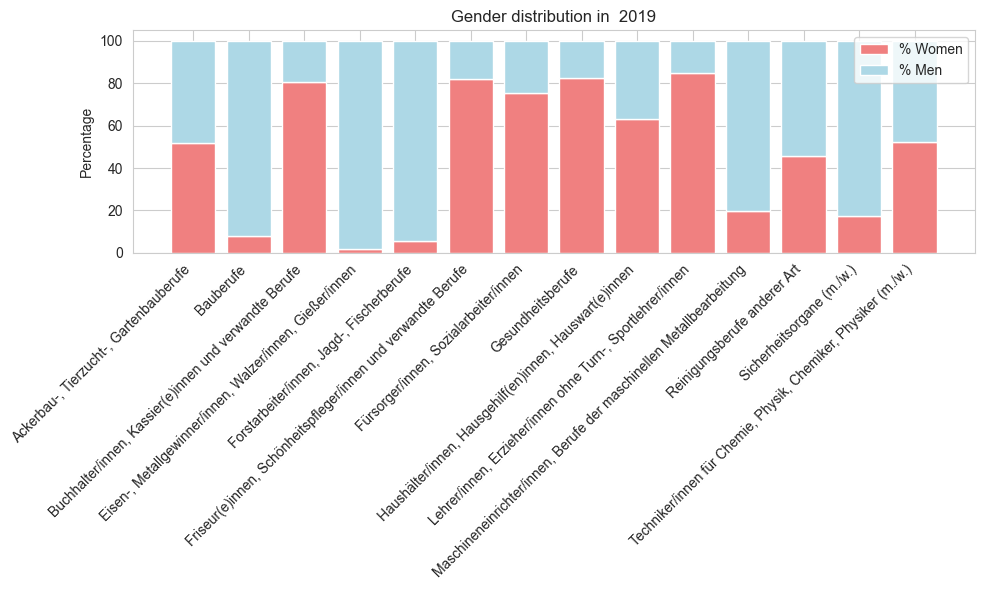

C:\Users\Marlis Tiefengraber\AppData\Local\Temp\ipykernel_15896\882419097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')


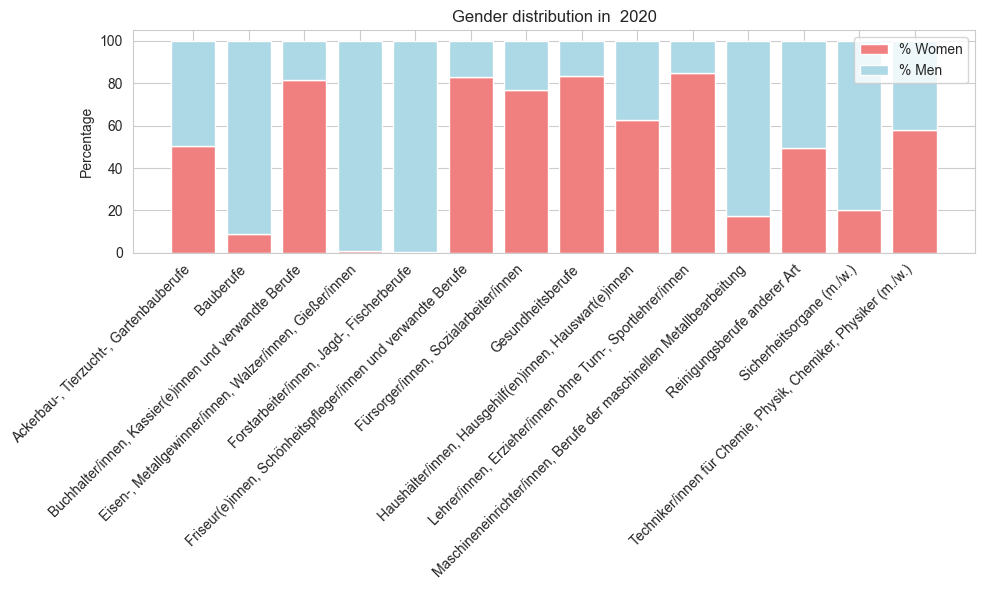

C:\Users\Marlis Tiefengraber\AppData\Local\Temp\ipykernel_15896\882419097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')


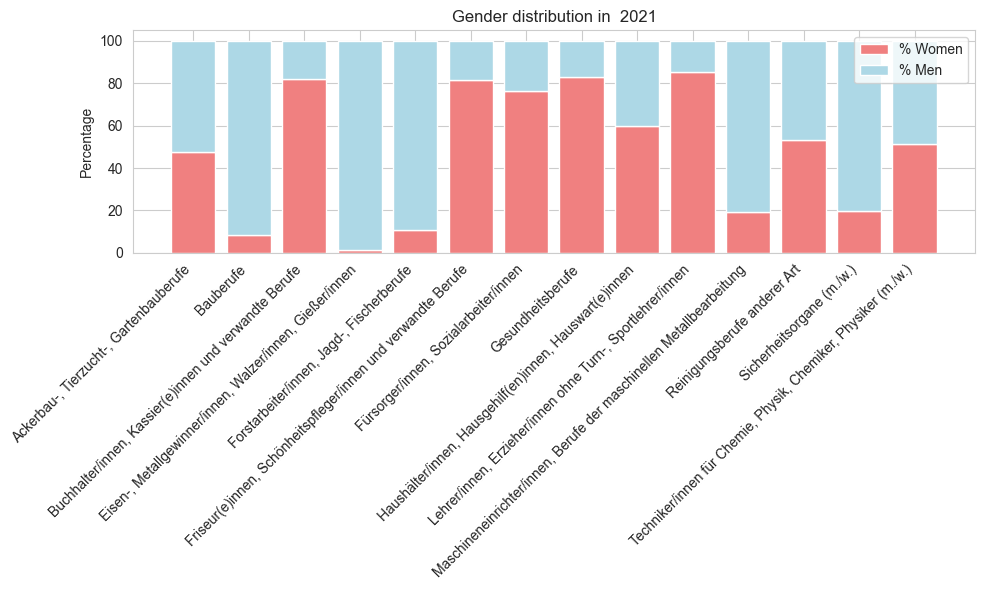

C:\Users\Marlis Tiefengraber\AppData\Local\Temp\ipykernel_15896\882419097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')


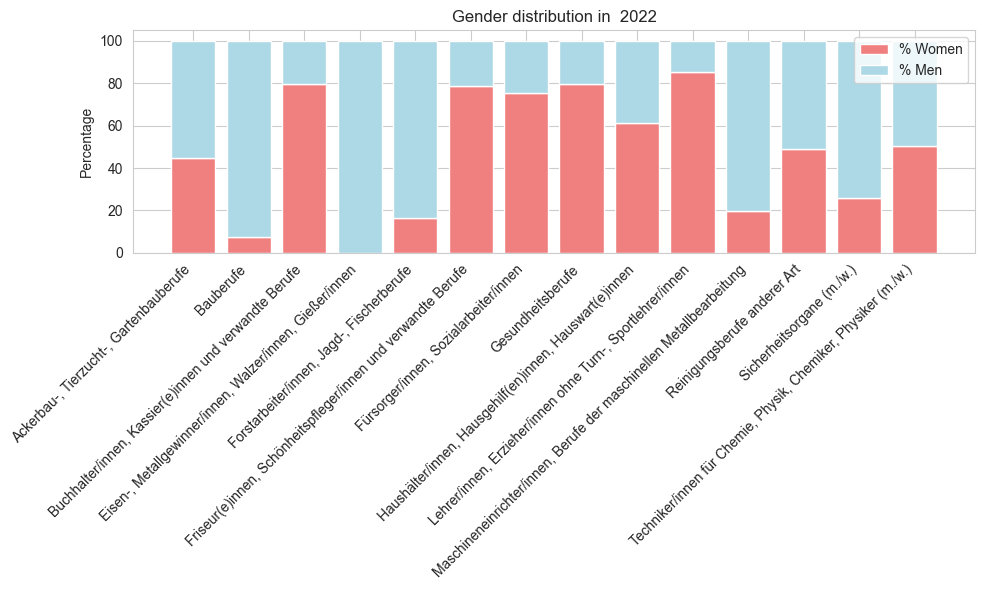

C:\Users\Marlis Tiefengraber\AppData\Local\Temp\ipykernel_15896\882419097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')


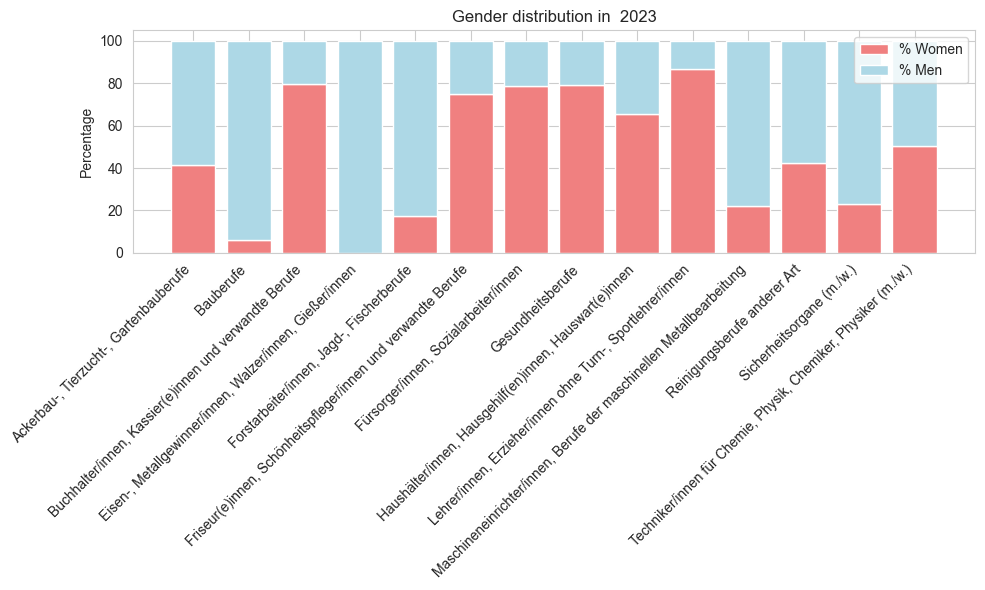

C:\Users\Marlis Tiefengraber\AppData\Local\Temp\ipykernel_15896\882419097.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')


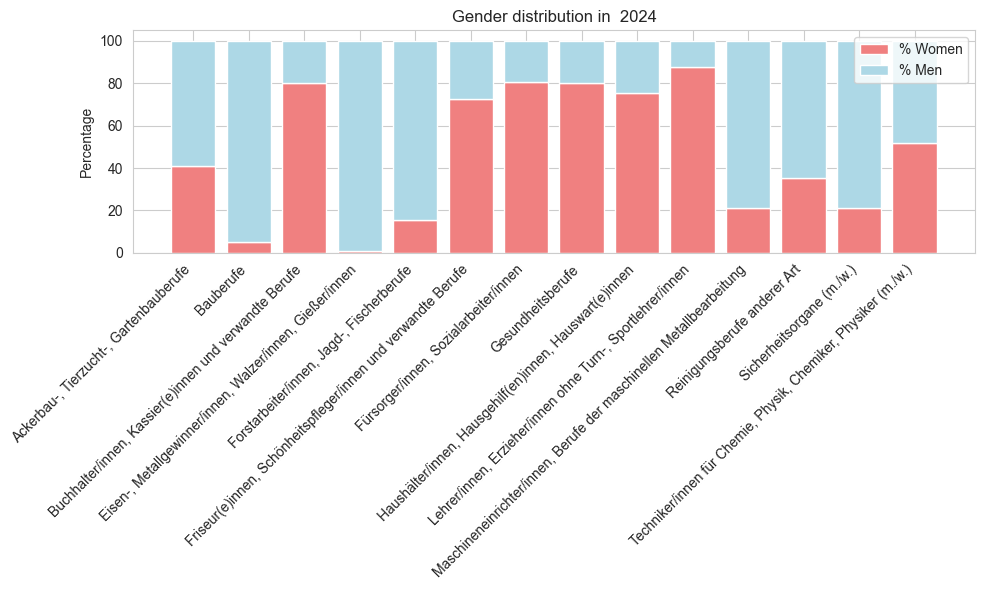

In [94]:
plt.figure(figsize=(10, 6))
years = df_jobs['Datum'].unique() # all years in data
for year in years:
    df_year = df_jobs[df_jobs['Datum'] == year]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df_year['Berufsobergruppe'], df_year['% Frauen'], label='% Women', color='lightcoral')
    ax.bar(df_year['Berufsobergruppe'], df_year['% Männer'], bottom=df_year['% Frauen'], label='% Men', color='lightblue')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Gender distribution in  {year}')
    ax.set_xticklabels(df_year['Berufsobergruppe'], rotation=45, ha='right')
    
    # Add a legend
    ax.legend(loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()

to get a better grasp on the development of percentages of women and men in the chosen job groups, plot each job group separately 

to see the general trend of the gender distribution add a trend line and capture its slope

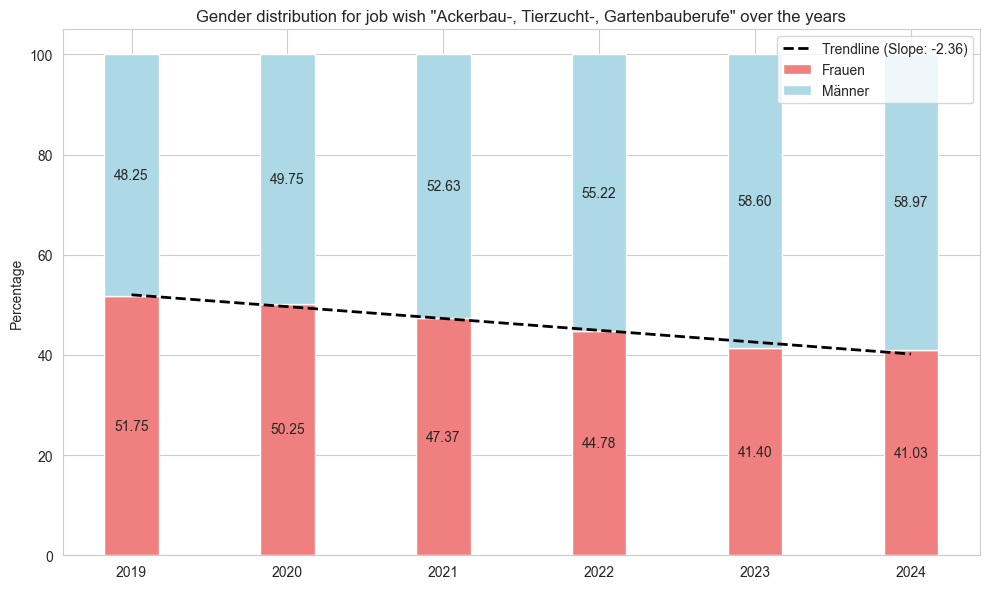

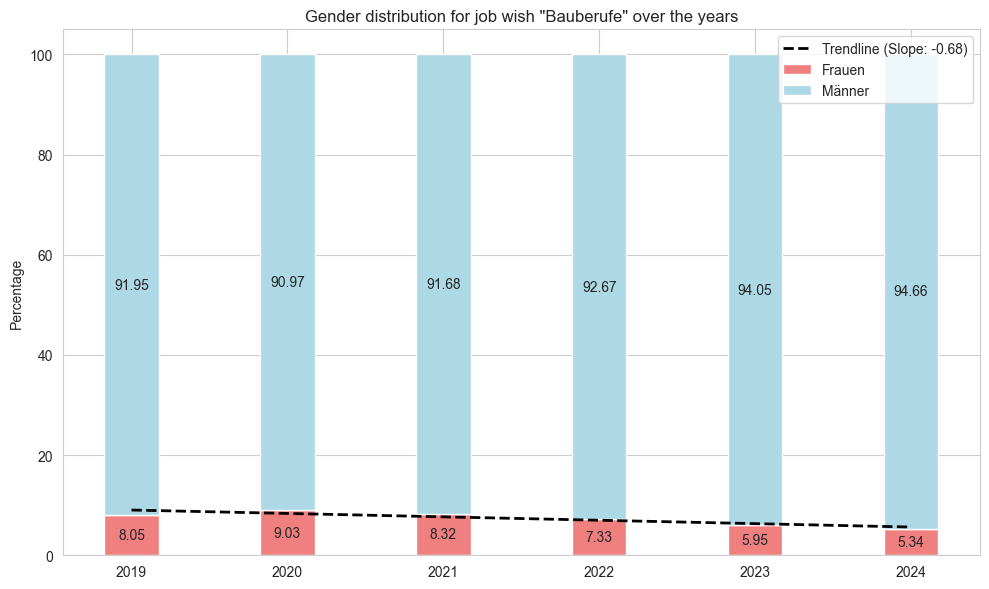

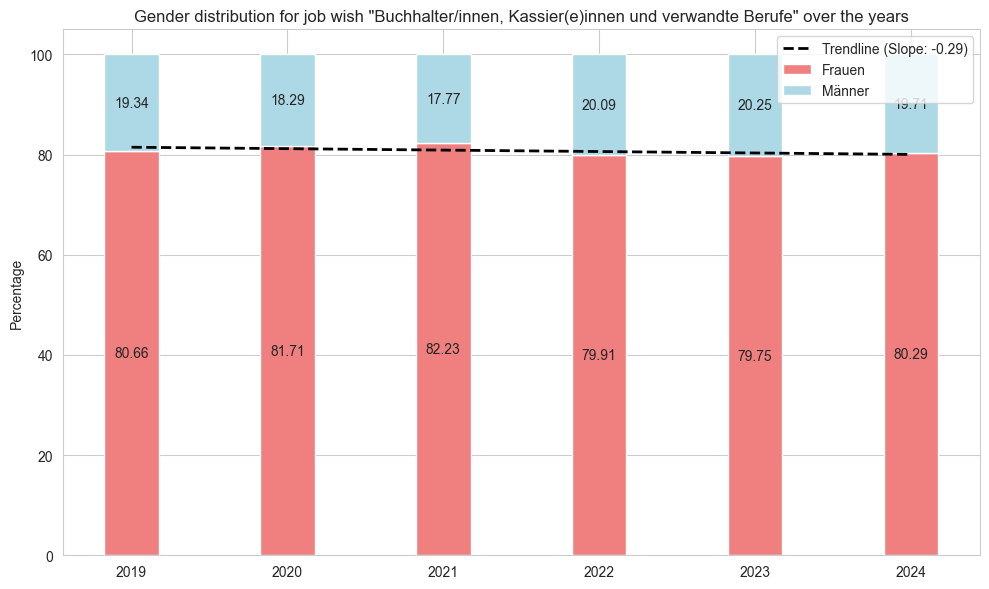

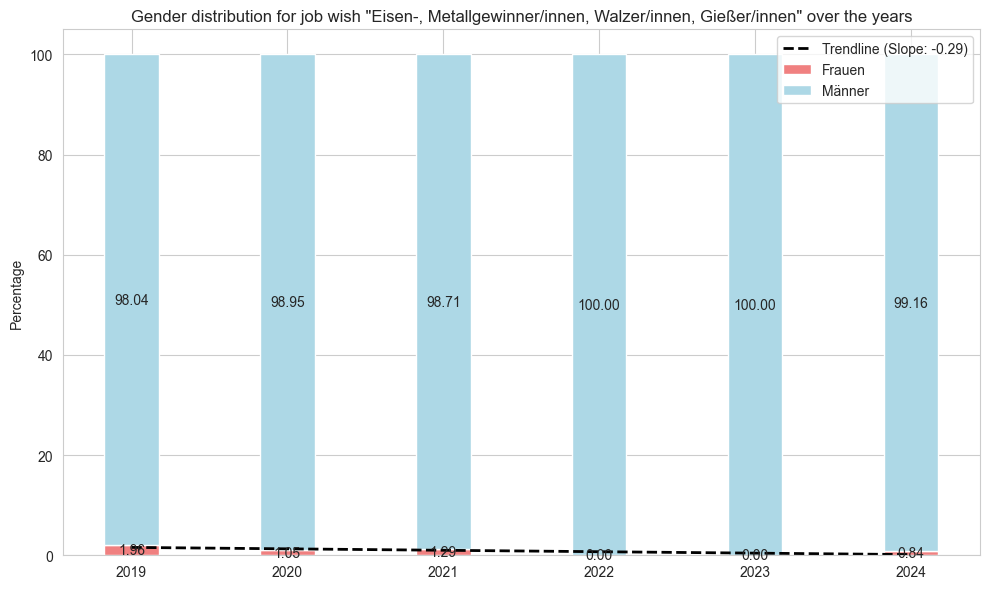

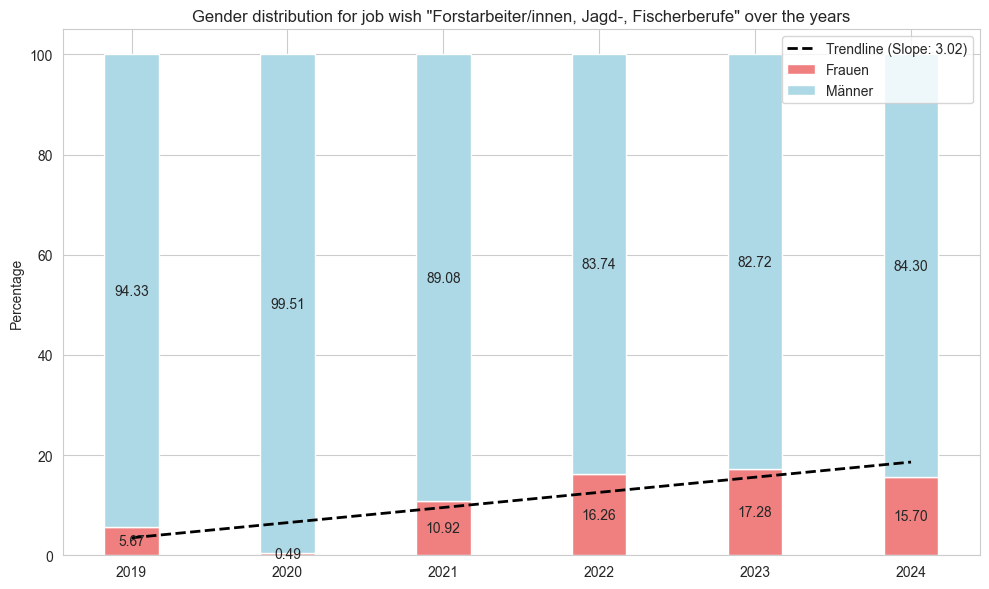

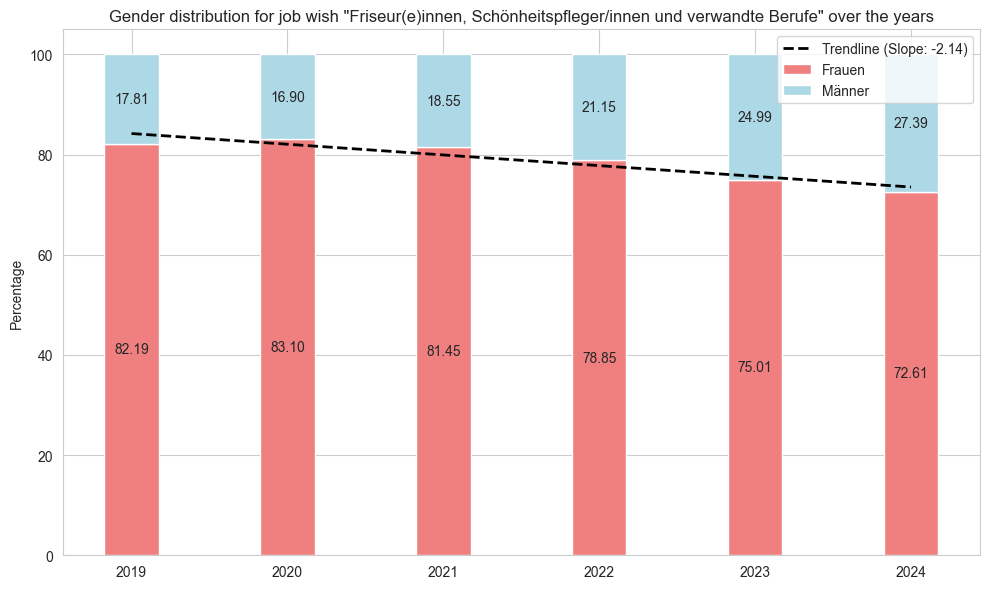

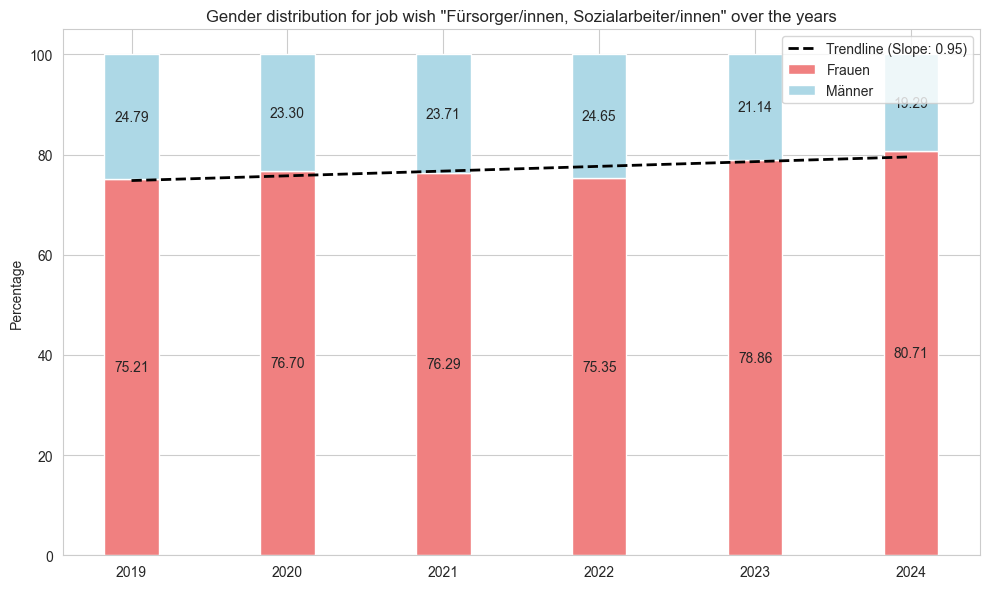

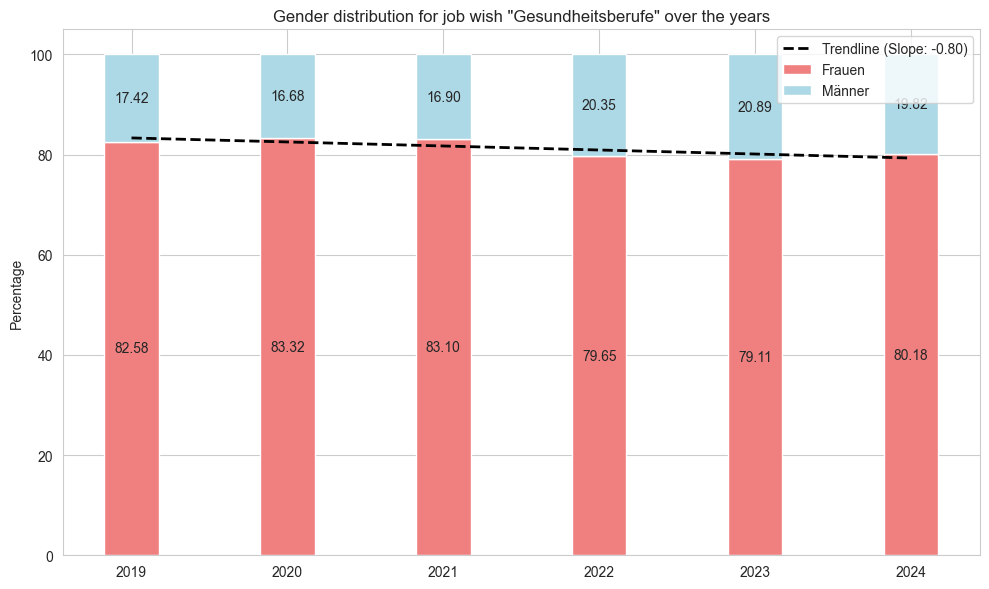

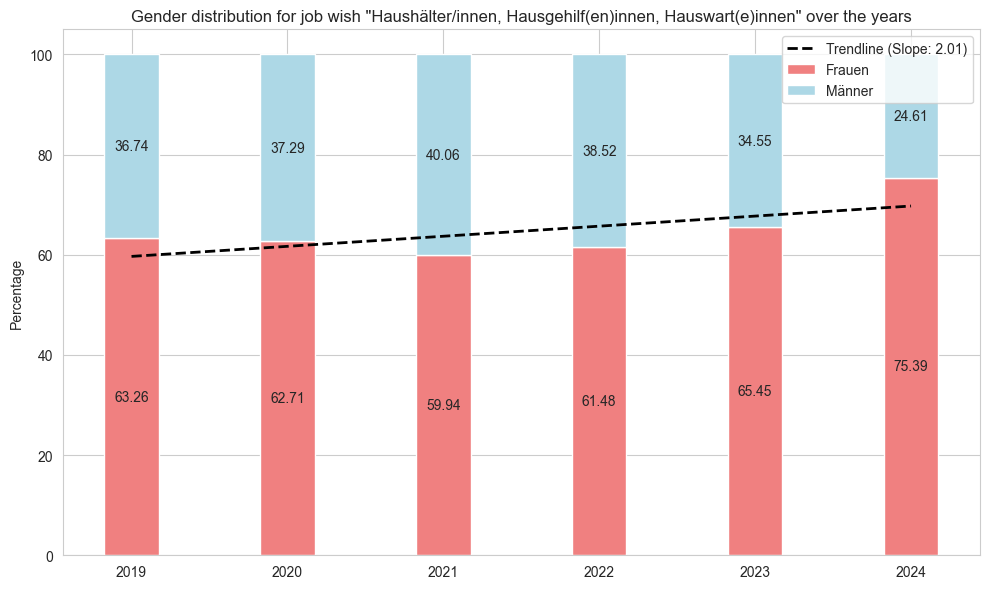

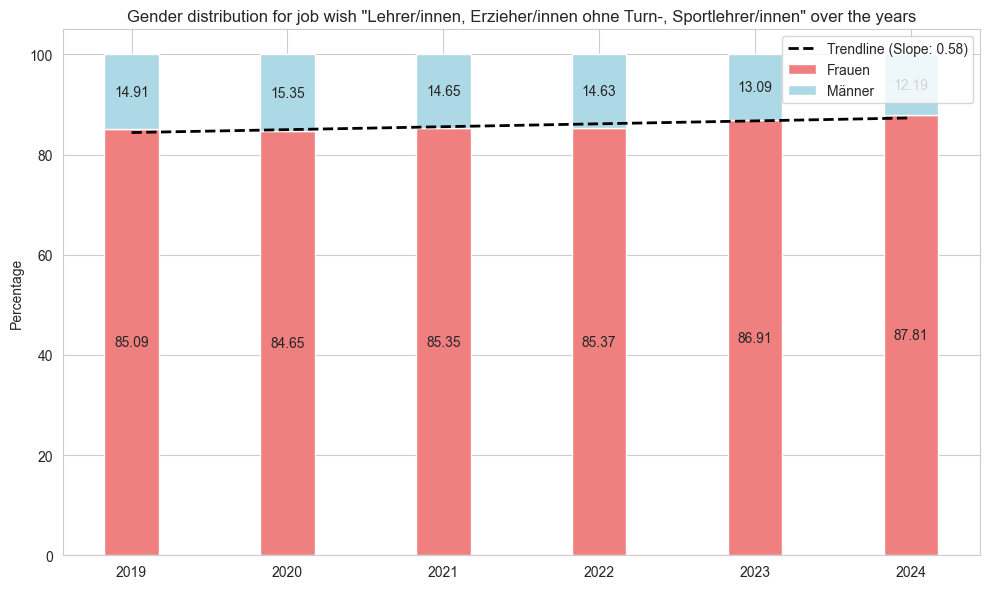

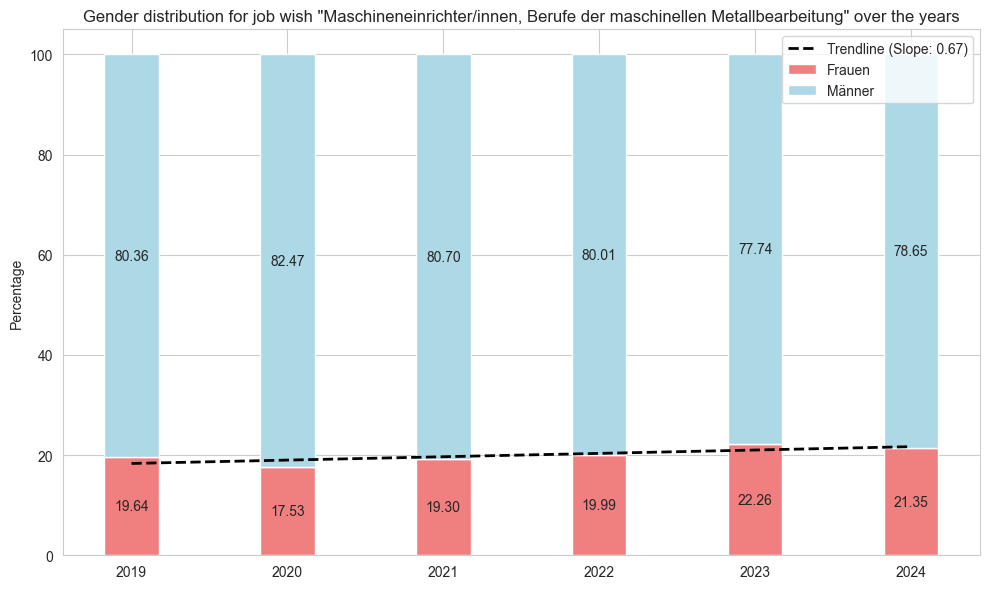

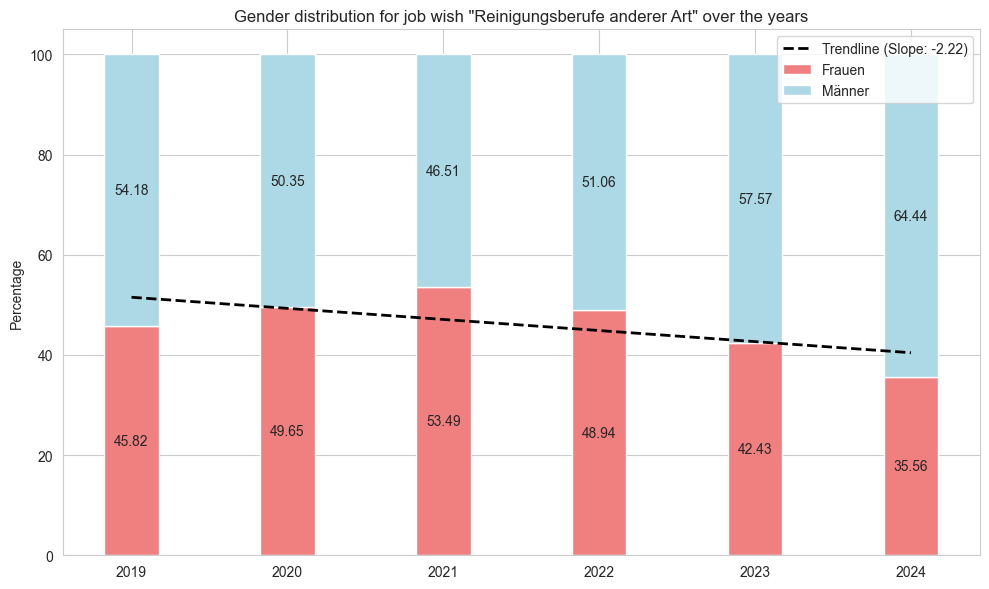

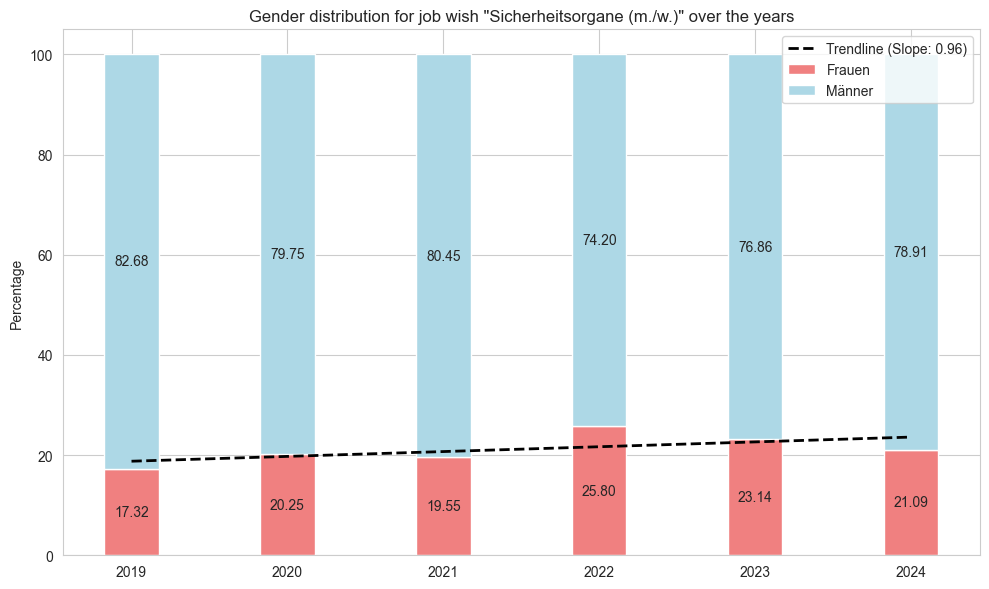

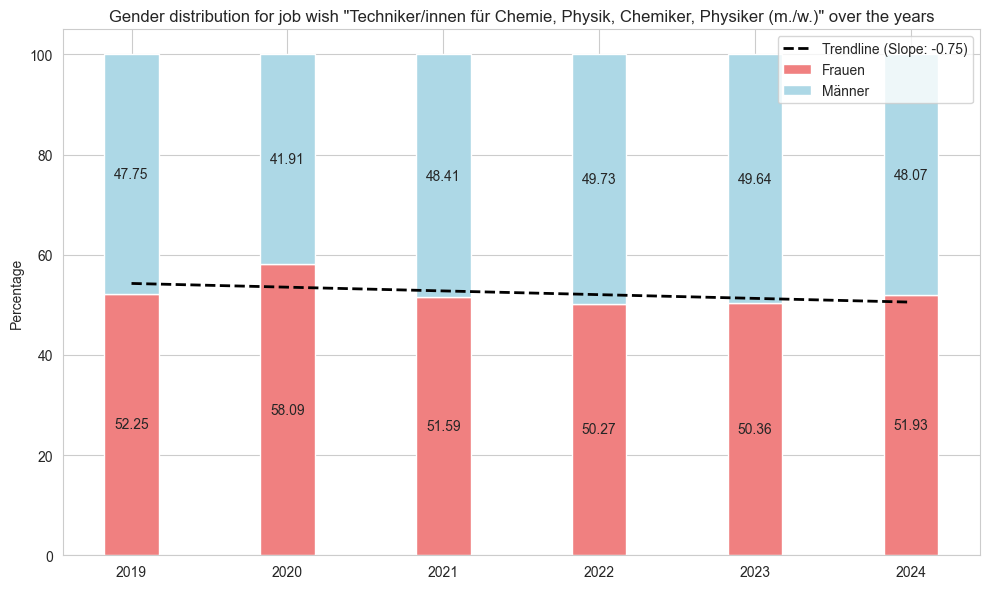

In [95]:
from sklearn.linear_model import LinearRegression
job_groups = df_jobs['Berufsobergruppe'].unique()
beruf_slope = {}

# for each job_group
for job_group in job_groups:
    df_job_group = df_jobs[df_jobs['Berufsobergruppe'] == job_group]
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    years = df_job_group['Datum'].unique()
    
    ax.bar(df_job_group['Datum'], df_job_group['% Frauen'], width=bar_width, label='Frauen', color='lightcoral')
    ax.bar(df_job_group['Datum'], df_job_group['% Männer'], bottom=df_job_group['% Frauen'], width=bar_width, label='Männer', color='lightblue')
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', label_type='center')
    
    ax.set_ylabel('Percentage')
    ax.set_title(f'Gender distribution for job wish "{job_group}" over the years')
    ax.set_xticks(years)
    ax.set_xticklabels(years)
    
    x_years = np.array(df_job_group['Datum']).reshape(-1, 1)  # reshape for LinearRegression
    y_frauen = df_job_group['% Frauen'].values
    
    model = LinearRegression()
    model.fit(x_years, y_frauen)
    y_trend = model.predict(x_years)
    slope = model.coef_[0]
    beruf_slope[job_group] = slope
    
    ax.plot(df_job_group['Datum'], y_trend, color='black', linestyle='--', linewidth=2, label=f'Trendline (Slope: {slope:.2f})')
    ax.legend(loc='upper right')
    # Show the plot
    plt.tight_layout()
    plt.show()

In [96]:
print('Female jobs:')
print('Negative slope = growing percentage of men')
gesamt_slope = 0
for beruf, slope in beruf_slope.items():
    if beruf in female_jobs:
        gesamt_slope += slope
        print(f'Job: {beruf}, Slope: {slope:.2f}')
        
print(f'Overall slope: {gesamt_slope:.2f}')

Female jobs:
Negative slope = growing percentage of men
Job: Buchhalter/innen, Kassier(e)innen und verwandte Berufe, Slope: -0.29
Job: Friseur(e)innen, Schönheitspfleger/innen und verwandte Berufe, Slope: -2.14
Job: Fürsorger/innen, Sozialarbeiter/innen, Slope: 0.95
Job: Gesundheitsberufe, Slope: -0.80
Job: Haushälter/innen, Hausgehilf(en)innen, Hauswart(e)innen, Slope: 2.01
Job: Lehrer/innen, Erzieher/innen ohne Turn-, Sportlehrer/innen, Slope: 0.58
Job: Reinigungsberufe anderer Art, Slope: -2.22
Overall slope: -1.90


In [97]:
print('Male jobs:')
print('Positive slope = growing percentage of women')
gesamt_slope = 0
for beruf, slope in beruf_slope.items():
    if beruf in male_jobs:
        gesamt_slope += slope
        print(f'Job: {beruf}, Slope: {slope:.2f}')
        
print(f'Overall slop: {gesamt_slope:.2f}')

Male jobs:
Positive slope = growing percentage of women
Job: Ackerbau-, Tierzucht-, Gartenbauberufe, Slope: -2.36
Job: Bauberufe, Slope: -0.68
Job: Eisen-, Metallgewinner/innen, Walzer/innen, Gießer/innen, Slope: -0.29
Job: Forstarbeiter/innen, Jagd-, Fischerberufe, Slope: 3.02
Job: Maschineneinrichter/innen, Berufe der maschinellen Metallbearbeitung, Slope: 0.67
Job: Sicherheitsorgane (m./w.), Slope: 0.96
Job: Techniker/innen für Chemie, Physik, Chemiker, Physiker (m./w.), Slope: -0.75
Overall slop: 0.58


split into separate dataframes first for gendered job and then for age group (using the dataframe including age groups from before)

this is necessary as next, percentages for age groups and gendered jobs need to be calculated separately

In [98]:
df_malejobs = df_jobs_age[df_jobs_age['Berufsobergruppe'].isin(male_jobs)]
df_malejobs_u30 = df_malejobs[df_malejobs['Alter_bis'] <= 30]
df_malejobs_o30 = df_malejobs[df_malejobs['Alter_bis'] > 30]
df_malejobs_u30.head()

,Datum,Berufsobergruppe,Alter_bis,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",19,2917.0,2000.0,4917.0,59.324792,40.675208
1,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",24,1811.0,1627.0,3438.0,52.675974,47.324026
2,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",29,659.0,683.0,1342.0,49.105812,50.894188
20,2019,Bauberufe,19,1442.0,8873.0,10315.0,13.979641,86.020359
21,2019,Bauberufe,24,486.0,5403.0,5889.0,8.252674,91.747326


In [99]:
df_femalejobs = df_jobs_age[df_jobs_age['Berufsobergruppe'].isin(female_jobs)]
df_femalejobs_u30 = df_femalejobs[df_femalejobs['Alter_bis'] <= 30]
df_femalejobs_o30 = df_femalejobs[df_femalejobs['Alter_bis'] > 30]
df_femalejobs_u30.head()

,Datum,Berufsobergruppe,Alter_bis,Frauen,Männer,Gesamt,% Frauen,% Männer
68,2019,"Buchhalter/innen, Kassier(e)innen und verwandt...",19,237.0,81.0,318.0,74.528302,25.471698
69,2019,"Buchhalter/innen, Kassier(e)innen und verwandt...",24,1071.0,502.0,1573.0,68.086459,31.913541
70,2019,"Buchhalter/innen, Kassier(e)innen und verwandt...",29,1287.0,309.0,1596.0,80.639098,19.360902
148,2019,"Friseur(e)innen, Schönheitspfleger/innen und v...",19,7113.0,1670.0,8783.0,80.985996,19.014004
149,2019,"Friseur(e)innen, Schönheitspfleger/innen und v...",24,4101.0,1112.0,5213.0,78.668713,21.331287


sum up the yearly data per age group to re-calculate general statistics/percentages per age group and gender

goal is to see which percentage of women and men wanted to work in opposite gender jobs per year per age group

In [100]:
df_malejobs_u30_yearly = df_malejobs_u30.groupby(['Datum']).agg({ # male jobs under 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_malejobs_u30_yearly['% Frauen'] = (df_malejobs_u30_yearly['Frauen'] / df_malejobs_u30_yearly['Gesamt']) * 100
df_malejobs_u30_yearly['% Männer'] = (df_malejobs_u30_yearly['Männer'] / df_malejobs_u30_yearly['Gesamt']) * 100

df_malejobs_o30_yearly = df_malejobs_o30.groupby(['Datum']).agg({ # male jobs over 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_malejobs_o30_yearly['% Frauen'] = (df_malejobs_o30_yearly['Frauen'] / df_malejobs_o30_yearly['Gesamt']) * 100
df_malejobs_o30_yearly['% Männer'] = (df_malejobs_o30_yearly['Männer'] / df_malejobs_o30_yearly['Gesamt']) * 100

df_malejobs_u30_yearly.head()

,Datum,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,8109.0,23196.0,31305.0,25.903210,74.096790
1,2020,7218.0,21255.0,28473.0,25.350332,74.649668
2,2021,7520.0,23137.0,30657.0,24.529471,75.470529
3,2022,7070.0,23401.0,30471.0,23.202389,76.797611
4,2023,6781.0,26128.0,32909.0,20.605306,79.394694


In [101]:
df_femalejobs_u30_yearly = df_femalejobs_u30.groupby(['Datum']).agg({ # female jobs under 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_femalejobs_u30_yearly['% Frauen'] = (df_femalejobs_u30_yearly['Frauen'] / df_femalejobs_u30_yearly['Gesamt']) * 100
df_femalejobs_u30_yearly['% Männer'] = (df_femalejobs_u30_yearly['Männer'] / df_femalejobs_u30_yearly['Gesamt']) * 100

df_femalejobs_o30_yearly = df_femalejobs_o30.groupby(['Datum']).agg({ # female jobs over 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_femalejobs_o30_yearly['% Frauen'] = (df_femalejobs_o30_yearly['Frauen'] / df_femalejobs_o30_yearly['Gesamt']) * 100
df_femalejobs_o30_yearly['% Männer'] = (df_femalejobs_o30_yearly['Männer'] / df_femalejobs_o30_yearly['Gesamt']) * 100

df_femalejobs_u30_yearly.head()

,Datum,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,29823.0,7764.0,37587.0,79.343922,20.656078
1,2020,26931.0,6631.0,33562.0,80.242536,19.757464
2,2021,31566.0,8358.0,39924.0,79.065224,20.934776
3,2022,31204.0,9517.0,40721.0,76.628766,23.371234
4,2023,33901.0,11482.0,45383.0,74.699777,25.300223


Plot the previously calculated data to prove or disprove the hypothesis that 
##### the percentage of people under 30 who want to work in jobs mostly dominated by the opposite gender is higher than the percentage of people over 30 #####

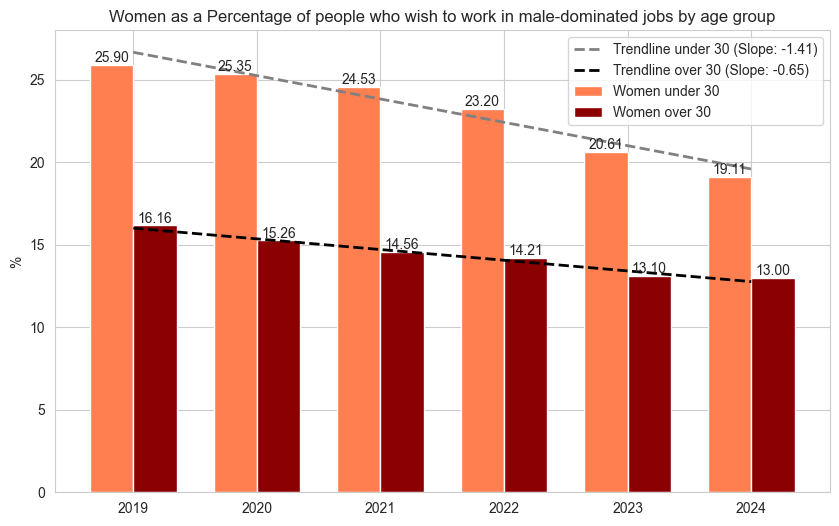

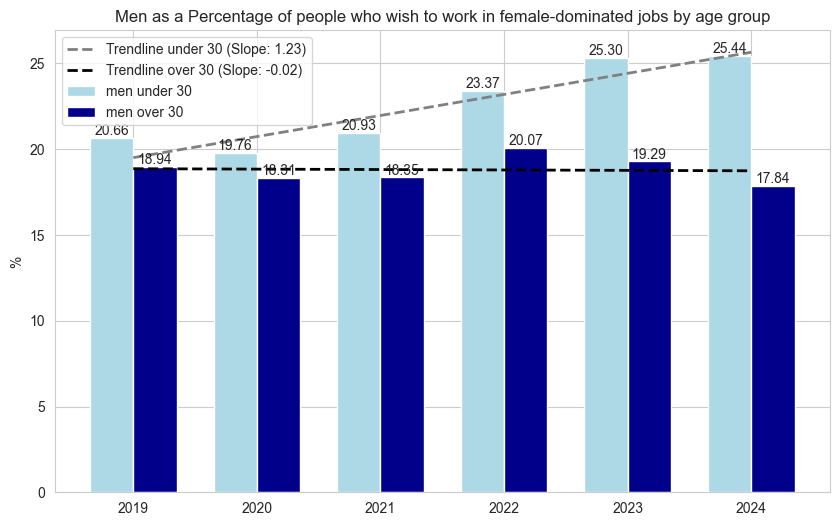

In [109]:
beruf_slope = {}
# Plot women % in male jobs 
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
ax.bar(df_malejobs_u30_yearly['Datum'] - bar_width/2, df_malejobs_u30_yearly['% Frauen'], width = bar_width, label='Women under 30', color='coral')
ax.bar(df_malejobs_o30_yearly['Datum'] + bar_width/2, df_malejobs_o30_yearly['% Frauen'], width = bar_width,  label='Women over 30', color='darkred')

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.2f')

# women under 30
x_years = np.array(df_malejobs_u30_yearly['Datum']).reshape(-1, 1)  # reshape for LinearRegression
y_frauen = df_malejobs_u30_yearly['% Frauen'].values
model = LinearRegression()
model.fit(x_years, y_frauen)
y_trend = model.predict(x_years)
slope = model.coef_[0]
beruf_slope['women_in_malejobs_u30'] = slope

ax.plot(df_malejobs_u30_yearly['Datum'], y_trend, color='grey', linestyle='--', linewidth=2, label=f'Trendline under 30 (Slope: {slope:.2f})')

# women over 30
x_years = np.array(df_malejobs_o30_yearly['Datum']).reshape(-1, 1)  # reshape for LinearRegression
y_frauen = df_malejobs_o30_yearly['% Frauen'].values
model = LinearRegression()
model.fit(x_years, y_frauen)
y_trend = model.predict(x_years)
slope = model.coef_[0]
beruf_slope['women_in_malejobs_o30'] = slope

ax.plot(df_malejobs_o30_yearly['Datum'], y_trend, color='black', linestyle='--', linewidth=2, label=f'Trendline over 30 (Slope: {slope:.2f})')

ax.set_ylabel('%')
ax.set_title('Women as a Percentage of people who wish to work in male-dominated jobs by age group')
ax.legend()

plt.show()

# plot men % in female jobs
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_femalejobs_u30_yearly['Datum'] - bar_width/2, df_femalejobs_u30_yearly['% Männer'], width = bar_width, label='men under 30', color='lightblue', )
ax.bar(df_femalejobs_o30_yearly['Datum'] + bar_width/2, df_femalejobs_o30_yearly['% Männer'], width = bar_width, label='men over 30', color='darkblue', )

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.2f')

# men under 30
x_years = np.array(df_femalejobs_u30_yearly['Datum']).reshape(-1, 1)  # reshape for LinearRegression
y_men = df_femalejobs_u30_yearly['% Männer'].values
model = LinearRegression()
model.fit(x_years, y_men)
y_trend = model.predict(x_years)
slope = model.coef_[0]
beruf_slope['men_in_femalejobs_u30'] = slope

ax.plot(df_femalejobs_u30_yearly['Datum'], y_trend, color='grey', linestyle='--', linewidth=2, label=f'Trendline under 30 (Slope: {slope:.2f})')

# men over 30
x_years = np.array(df_femalejobs_o30_yearly['Datum']).reshape(-1, 1)  # reshape for LinearRegression
y_men = df_femalejobs_o30_yearly['% Männer'].values
model = LinearRegression()
model.fit(x_years, y_men)
y_trend = model.predict(x_years)
slope = model.coef_[0]
beruf_slope['men_in_femalejobs_o30'] = slope

ax.plot(df_femalejobs_o30_yearly['Datum'], y_trend, color='black', linestyle='--', linewidth=2, label=f'Trendline over 30 (Slope: {slope:.2f})')

ax.set_ylabel('%')
ax.set_title('Men as a Percentage of people who wish to work in female-dominated jobs by age group')
ax.legend()

plt.show()

look at the trendlines to see that while the shares of women with job aspirations for male jobs are sinking for both age groups, the shares of men under 30 with job aspirations for female jobs are rising quite steadily

In [111]:
for beruf, slope in beruf_slope.items():
    print(f'{beruf}, Slope: {slope:.2f}')

women_in_malejobs_u30, Slope: -1.41
women_in_malejobs_o30, Slope: -0.65
men_in_femalejobs_u30, Slope: 1.23
men_in_femalejobs_o30, Slope: -0.02


highlight the result of the hypothesis testing by printing how many percent more women and men under 30 have a job aspiration that is typically of the opposite gender

In [103]:
comp_men_yearly = df_femalejobs_u30_yearly['% Männer'] - df_femalejobs_o30_yearly['% Männer']
comp_women_yearly = df_malejobs_u30_yearly['% Frauen'] - df_malejobs_o30_yearly['% Frauen']
for i, year in enumerate(years):
    print(f'{comp_women_yearly[i]: .2f}% more women under 30 with a male career aspiration than women over 30 ({year}) ')
    print(f'{comp_men_yearly[i]: .2f}% more men under 30 with a female career aspiration than men over 30 ({year}) ')

 9.74% more women under 30 with a male career aspiration than women over 30 (2019) 
 1.71% more men under 30 with a female career aspiration than men over 30 (2019) 
 10.09% more women under 30 with a male career aspiration than women over 30 (2020) 
 1.45% more men under 30 with a female career aspiration than men over 30 (2020) 
 9.97% more women under 30 with a male career aspiration than women over 30 (2021) 
 2.58% more men under 30 with a female career aspiration than men over 30 (2021) 
 9.00% more women under 30 with a male career aspiration than women over 30 (2022) 
 3.30% more men under 30 with a female career aspiration than men over 30 (2022) 
 7.51% more women under 30 with a male career aspiration than women over 30 (2023) 
 6.01% more men under 30 with a female career aspiration than men over 30 (2023) 
 6.12% more women under 30 with a male career aspiration than women over 30 (2024) 
 7.60% more men under 30 with a female career aspiration than men over 30 (2024) 


to see more clearly why the results turned out that way, recalculate the statistics to show numbers for each job group per year separately to visualize the differences per job group

In [104]:
# recalculate percent per date and job group
df_malejobs_u30_agg = df_malejobs_u30.groupby(['Datum', 'Berufsobergruppe']).agg({ # male jobs under 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_malejobs_u30_agg['% Frauen'] = (df_malejobs_u30_agg['Frauen'] / df_malejobs_u30_agg['Gesamt']) * 100
df_malejobs_u30_agg['% Männer'] = (df_malejobs_u30_agg['Männer'] / df_malejobs_u30_agg['Gesamt']) * 100

df_malejobs_o30_agg = df_malejobs_o30.groupby(['Datum', 'Berufsobergruppe']).agg({ # male jobs over 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_malejobs_o30_agg['% Frauen'] = (df_malejobs_o30_agg['Frauen'] / df_malejobs_o30_agg['Gesamt']) * 100
df_malejobs_o30_agg['% Männer'] = (df_malejobs_o30_agg['Männer'] / df_malejobs_o30_agg['Gesamt']) * 100

df_malejobs_u30_agg

,Datum,Berufsobergruppe,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,"Ackerbau-, Tierzucht-, Gartenbauberufe",5387.0,4310.0,9697.0,55.553264,44.446736
1,2019,Bauberufe,2088.0,16856.0,18944.0,11.021959,88.978041
2,2019,"Eisen-, Metallgewinner/innen, Walzer/innen, Gi...",0.0,69.0,69.0,0.000000,100.000000
3,2019,"Forstarbeiter/innen, Jagd-, Fischerberufe",2.0,87.0,89.0,2.247191,97.752809
4,2019,"Maschineneinrichter/innen, Berufe der maschine...",445.0,1517.0,1962.0,22.680938,77.319062
5,2019,Sicherheitsorgane (m./w.),47.0,270.0,317.0,14.826498,85.173502
6,2019,"Techniker/innen für Chemie, Physik, Chemiker, ...",140.0,87.0,227.0,61.674009,38.325991
7,2020,"Ackerbau-, Tierzucht-, Gartenbauberufe",4428.0,3805.0,8233.0,53.783554,46.216446
8,2020,Bauberufe,2165.0,15149.0,17314.0,12.504332,87.495668
9,2020,"Eisen-, Metallgewinner/innen, Walzer/innen, Gi...",0.0,63.0,63.0,0.000000,100.000000


In [105]:
df_femalejobs_u30_agg = df_femalejobs_u30.groupby(['Datum', 'Berufsobergruppe']).agg({ # female jobs under 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_femalejobs_u30_agg['% Frauen'] = (df_femalejobs_u30_agg['Frauen'] / df_femalejobs_u30_agg['Gesamt']) * 100
df_femalejobs_u30_agg['% Männer'] = (df_femalejobs_u30_agg['Männer'] / df_femalejobs_u30_agg['Gesamt']) * 100

df_femalejobs_o30_agg = df_femalejobs_o30.groupby(['Datum', 'Berufsobergruppe']).agg({ # female jobs over 30
    'Frauen': 'sum',
    'Männer': 'sum',
    'Gesamt': 'sum'
}).reset_index()
df_femalejobs_o30_agg['% Frauen'] = (df_femalejobs_o30_agg['Frauen'] / df_femalejobs_o30_agg['Gesamt']) * 100
df_femalejobs_o30_agg['% Männer'] = (df_femalejobs_o30_agg['Männer'] / df_femalejobs_o30_agg['Gesamt']) * 100

df_femalejobs_u30_agg

,Datum,Berufsobergruppe,Frauen,Männer,Gesamt,% Frauen,% Männer
0,2019,"Buchhalter/innen, Kassier(e)innen und verwandt...",2595.0,892.0,3487.0,74.419272,25.580728
1,2019,"Friseur(e)innen, Schönheitspfleger/innen und v...",13215.0,3239.0,16454.0,80.314817,19.685183
2,2019,"Fürsorger/innen, Sozialarbeiter/innen",2146.0,936.0,3082.0,69.630110,30.369890
3,2019,Gesundheitsberufe,7439.0,1733.0,9172.0,81.105539,18.894461
4,2019,"Haushälter/innen, Hausgehilf(en)innen, Hauswar...",361.0,156.0,517.0,69.825919,30.174081
5,2019,"Lehrer/innen, Erzieher/innen ohne Turn-, Sport...",3826.0,431.0,4257.0,89.875499,10.124501
6,2019,Reinigungsberufe anderer Art,241.0,377.0,618.0,38.996764,61.003236
7,2020,"Buchhalter/innen, Kassier(e)innen und verwandt...",2213.0,700.0,2913.0,75.969791,24.030209
8,2020,"Friseur(e)innen, Schönheitspfleger/innen und v...",12575.0,2993.0,15568.0,80.774666,19.225334
9,2020,"Fürsorger/innen, Sozialarbeiter/innen",1744.0,694.0,2438.0,71.534044,28.465956


plot the previously calculated data to show the result of the hypothesis testing per job group

this is done to visualize which job groups contribute more or less strongly to the result

In [106]:
for job in male_jobs:
    df_job_u30 = df_malejobs_u30_agg[df_malejobs_u30_agg['Berufssobergruppe'] == job]
    df_job_o30 = df_malejobs_o30_agg[df_malejobs_o30_agg['Berufsobergruppe'] == job]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    ax.bar(df_job_u30['Datum'] - bar_width/2, df_job_u30['% Frauen'], width = bar_width, label='Women under 30', color='coral')
    ax.bar(df_job_o30['Datum'] + bar_width/2, df_job_o30['% Frauen'], width = bar_width,  label='Women over 30', color='darkred')
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f')
    
    # Labels and title
    ax.set_ylabel('%')
    ax.set_title(f'Women as a Percentage of people who wish to work in "{job}" by age group')
    ax.legend()
    plt.show()
    
for job in female_jobs:
    df_job_u30 = df_femalejobs_u30_agg[df_femalejobs_u30_agg['Berufsobergruppe'] == job]
    df_job_o30 = df_femalejobs_o30_agg[df_femalejobs_o30_agg['Berufsobergruppe'] == job]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    ax.bar(df_job_u30['Datum'] - bar_width/2, df_job_u30['% Männer'], width = bar_width, label='Men under 30', color='lightblue')
    ax.bar(df_job_o30['Datum'] + bar_width/2, df_job_o30['% Männer'], width = bar_width,  label='Men over 30', color='darkblue')
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f')
    
    # Labels and title
    ax.set_ylabel('%')
    ax.set_title(f'Men as a Percentage of people who wish to work in "{job}" by age group')
    ax.legend()
    plt.show()

KeyError: 'Berufssobergruppe'

### E3-H4: "xxx"
Author: Group member 4


### E3-H5: "xxx"
Author: Group member 5
